<a id='Top'></a>

# <font color="#8333ff">P7: Effectuez une prédiction de revenus</font>

---

## Sommaire

[Mission 1 : données utilisées](#Mission1)   

[Mission 2 : distribution des revenus](#Mission2)  
- [1. Diversité des pays en termes de distribution des revenus](#Diversite)      
- [2. Courbe de Lorenz de chacun des pays choisis](#Lorenz)  
- [3. Évolution de l'indice de Gini au fil des ans](#Gini)  
- [4. Pays par indice de Gini](#PaysGini) 

[Mission 3 : classe des revenus des parents](#Mission3)  
- [Coefficients d'élasticité](#elasticite)  
- [Génération de la classe de revenu des parents](#classeparents)  

[Mission 4 : modélisation](#Mission4)  
- [1. Anova income ~ country](#Anova)  
- [2.a. Régression linéaire : income_mean + gini => income](#2a)  
- [2.b. Régression linéaire : log(income_mean) + gini => log(income)](#2b)  
- [3. Régression linéaire : log(income_mean) + gini + c_parent => log(income)](#3)

---

In [1]:
# Import des librairies
import numpy as np
print(f"numpy version {np.__version__}")
import pandas as pd
print(f"pandas version {pd.__version__}")
import matplotlib.pyplot as plt
import seaborn as sns
print(f"seaborn version {sns.__version__}")

# Pour l'OLS
import statsmodels.formula.api as smf
# Analyse de la variance
import statsmodels.api as sm
# Tests statistiques (Shapiro, KS)
import scipy.stats as st
# vérifier la colinéarité des variables
from statsmodels.stats.outliers_influence import variance_inflation_factor


# afficher les paragraphes en Markdown
from IPython.display import Markdown

# afficher les tableaux entiers
pd.set_option('display.max_rows', None, 'display.max_columns', None)

numpy version 1.18.1
pandas version 1.0.1
seaborn version 0.10.0


<a id='Mission1'></a>

# <font color='#FFCA36'>Mission 1</font>

# Résumé des données utilisées

Résumer les données utilisées :

- année(s) des données utilisées ;
- nombre de pays présents ;
- population couverte par l'analyse (en termes de pourcentage de la population mondiale).

## Table income

Source : World Income Distribution via Openclassrooms. 

In [2]:
# Import des données
inc = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/data-projet7.csv', decimal=',')

In [4]:
inc.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [3]:
inc.rename(columns = {'year_survey': 'year', 'country' : 'country_code'}, inplace=True)

In [4]:
inc.tail()

,country_code,year,quantile,nb_quantiles,income,gdpppp
11594,COD,2008,96,100,810.6233,303.19305
11595,COD,2008,97,100,911.7834,303.19305
11596,COD,2008,98,100,1057.8074,303.19305
11597,COD,2008,99,100,1286.6029,303.19305
11598,COD,2008,100,100,2243.1226,303.19305


In [5]:
inc.shape

(11599, 6)

Il manque visiblement une ligne (116 pays * 100 = 11600). Nous verrons laquelle plus loin. 

In [222]:
inc.describe(include = "all")

,country_code,year,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,THA,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,NaN,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,NaN,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,NaN,2008.000000,75.500000,100.0,7515.420900,1.877300e+04


La table comprend **116 pays**. Nous avons les codes mais pas les noms. 

In [223]:
inc.year.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

La table contient **7 années différentes**. 

In [224]:
# Par année
inc_gby = inc.groupby('year')['country_code'].nunique().to_frame()
inc_gby

,country_code
year,
2004,1
2006,5
2007,15
2008,76
2009,12
2010,6
2011,1


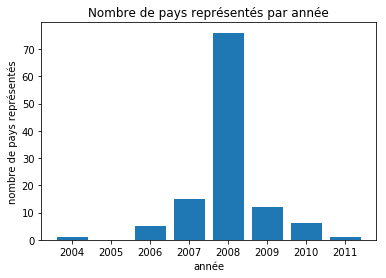

In [225]:
# Histogramme nb de pays/année
plt.bar(inc_gby.index, inc_gby.country_code)
plt.xlabel('année')
plt.ylabel('nombre de pays représentés')
plt.title('Nombre de pays représentés par année')

plt.savefig('fig1.jpeg')

On constate que 2008 est l'année la plus représentée. 

In [18]:
inc.country_code.unique()

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM',
       'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR', 'GEO',
       'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN', 'IND',
       'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KGZ', 'KHM', 'KOR', 'XKX', 'LAO', 'LBR', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE',
       'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'SWZ',
       'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR',
       'URY', 'USA', 'VEN', 'VNM', 'PSE', 'YEM', 'ZAF', 'COD'],
      dtype=object)

In [226]:
inc.groupby('country_code').nunique().sum()

country_code      116
year              116
quantile        11599
nb_quantiles      116
income          11599
gdpppp            114
dtype: int64

In [103]:
inc.isnull().sum()

country_code      0
year              0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

2 pays n'ont pas de données gdpppp. Voyons lesquels. 

In [105]:
nb_pays = inc.groupby('country_code').nunique()
nb_pays.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp
country_code,,,,,,
ALB,1,1,100,1,100,1
ARG,1,1,100,1,100,1
ARM,1,1,100,1,100,1
AUT,1,1,100,1,100,1
AZE,1,1,100,1,100,1


In [106]:
nb_pays[nb_pays['gdpppp']==0]

,country_code,year,quantile,nb_quantiles,income,gdpppp
country_code,,,,,,
PSE,1,1,100,1,100,0
XKX,1,1,100,1,100,0


Les gdp ppp de la Palestine et du Kosovo sont manquants. 

#### gdpppp manquants

**Que signifie gdp ppp ?**   
Gross domestic product (at purchasing power parity). En français : produit intérieur brut en parité du pouvoir d'achat ( PIB PPA).   
La PPA permet de mesurer combien une devise permet d’acheter de biens et services dans chacune des zones que l’on compare.

Nous allons compléter les gdp ppp manquants. 

- Source pour la Palestine : [World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?locations=PS)

In [6]:
inc.loc[inc['country_code'] == 'PSE', 'gdpppp'] = 3695.024

In [7]:
# Vérification au hasard
inc.loc[inc['country_code'] == 'PSE'].sample(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp
11226,PSE,2009,28,100,625.80804,3695.024


- Source pour le Kosovo : [World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?locations=XK)

In [8]:
inc.loc[inc['country_code'] == 'XKX', 'gdpppp'] = 7249.409

In [100]:
# inc2.loc[inc2['country_code'] == 'XKX', 'country_code'] = 'XKX'

In [106]:
# inc2.loc[inc2['country_code'] == 'XKX', 'country_name'] = 'Kosovo'

In [9]:
# Vérification au hasard
inc.loc[inc['country_code'] == 'XKX'].sample(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp
5851,XKX,2008,52,100,1872.0078,7249.409


In [111]:
inc.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
dtype: int64

In [235]:
inc.shape

(11599, 6)

## Table population

In [46]:
# Import des données (source FAO)
pop = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/pop04-11.csv')

In [237]:
pop.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2005,2005,1000 personnes,25654.277,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2006,2006,1000 personnes,26433.049,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2007,2007,1000 personnes,27100.536,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2008,2008,1000 personnes,27722.276,NaN


In [47]:
# Je conserve uniquement les colonnes utiles 
pop = pop[['Zone', 'Année', 'Valeur']]

In [48]:
# Je renomme les colonnes pour plus de clarté
pop.rename(columns = {
    'Zone' : 'country_name',
    'Année' : 'year',
    'Valeur' : 'population'
}, inplace=True)

In [49]:
# L'unité est pour 1000 personnes => je multiplie la colonne population par 1000
pop.population = (pop.population * 1000).astype(int)

In [50]:
pop.head()

,country_name,year,population
0,Afghanistan,2004,24726683
1,Afghanistan,2005,25654277
2,Afghanistan,2006,26433049
3,Afghanistan,2007,27100536
4,Afghanistan,2008,27722276


In [51]:
pop.shape

(1851, 3)

## Noms des pays 

Pour avoir les noms des pays, nous devons utiliser les codes ISO.  
Les codes ISO ne sont apparemment pas en accès libre. On les trouve sur plusieurs sites (par exemple Wikipedia). Comme source dans le cadre de ce projet celui qui m'a paru le plus "adapté" (plus facile à utiliser tout en étant visiblement fiable) est http://www.trucsweb.com/tutoriels/internet/iso_3166/

In [11]:
# Import des données
iso = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/country-code-fr.csv')

In [12]:
iso.head()

,Pays,ISO2,ISO3,ISOON
0,Afghanistan,AF,AFG,004
1,Îles Aland,AX,ALA,248
2,Albanie,AL,ALB,008
3,Algérie,DZ,DZA,012
4,Samoa américaines,AS,ASM,016


In [13]:
iso.rename(columns = {'Pays' : 'country_name', 'ISO3' : 'country_code'}, inplace = True)

In [14]:
iso = iso[['country_code', 'country_name']]

In [247]:
iso.head()

,country_code,country_name
0,AFG,Afghanistan
1,ALA,Îles Aland
2,ALB,Albanie
3,DZA,Algérie
4,ASM,Samoa américaines


In [15]:
iso.shape

(247, 2)

### Jointure 1 entre inc et iso pour avoir le nom du pays et le code du pays dans la même table

In [16]:
# Jointure de inc et iso
inc2 = pd.merge(inc, iso, how = 'left')
inc.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [143]:
# inc2.drop('country', axis = 1, inplace = True)

In [17]:
inc2.shape

(11599, 7)

In [18]:
inc2.isnull().sum()

country_code      0
year              0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
country_name    500
dtype: int64

**5 pays** n'ont pas de nom. Voyons lesquels. 

In [251]:
inc2[inc2['country_name'].isnull()].groupby(['country_code']).nunique()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,
EST,1,1,100,1,100,1,0
HRV,1,1,100,1,100,1,0
LAO,1,1,100,1,100,1,0
NER,1,1,100,1,100,1,0
XKX,1,1,100,1,100,1,0


Il s'agit de : 
- Estonie
- Croatie
- Laos
- Niger
- Kosovo

In [19]:
# Je complète les country_name manquants
inc2.loc[inc2['country_code'] == 'EST', 'country_name'] = 'Estonie'
inc2.loc[inc2['country_code'] == 'HRV', 'country_name'] = 'Croatie'
inc2.loc[inc2['country_code'] == 'LAO', 'country_name'] = 'République démocratique populaire lao'
inc2.loc[inc2['country_code'] == 'NER', 'country_name'] = 'Niger'
inc2.loc[inc2['country_code'] == 'XKX', 'country_name'] = 'Kosovo'

In [126]:
# Vérification
inc2[inc2['country_name'].isnull()].groupby(['country_code']).nunique()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,


### Vérification des données, colonne par colonne

In [23]:
# Pour retourner le nombre d'observations distinctes :
inc2b = inc2.groupby('country_code').nunique()

In [99]:
inc2b.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,
ALB,1,1,100,1,100,1,1
ARG,1,1,100,1,100,1,1
ARM,1,1,100,1,100,1,1
AUT,1,1,100,1,100,1,1
AZE,1,1,100,1,100,1,1


In [100]:
inc2b[inc2b.country_code!=1]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,


In [51]:
inc2b[inc2b.year!=1]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,


A chaque pays correspond une et une seule année.

In [52]:
inc2b[inc2b['quantile']!=100]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,
LTU,1,1,99,1,99,1,1


Il manque **un quantile pour la Lituanie.** 

In [53]:
inc2b[inc2b.nb_quantiles!=1]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,


In [54]:
inc2b[inc2b.income!=100]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,
LTU,1,1,99,1,99,1,1


In [55]:
inc2b[inc2b.gdpppp!=1]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,


In [57]:
inc2b[inc2b.country_name!=1]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
country_code,,,,,,,


### Complétude des données

#### Quantile manquant pour LTU

In [27]:
# Recherche du quantile manquant
ltu = inc2[inc2['country_code'] == 'LTU']

quant_ltu = list(ltu['quantile'])
tot_quant = list(range(1,100))

quant_manquant = []
for elt in tot_quant:
    if elt not in quant_ltu:
        quant_manquant.append(elt)

print(f'Le quantile manquant est le quantile {quant_manquant}')

Le quantile manquant est le quantile [41]


Il est possible de calculer ce quantile manquant en faisant la moyenne avec les quantiles précédent et suivant.

In [60]:
(float(inc2.iloc[6239]['income']) +  float(inc2.iloc[6240]['income'])) / 2

4882.14065

In [62]:
inc2.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
0,ALB,2008,1,100,728.89795,7297.0,Albanie
1,ALB,2008,2,100,916.66235,7297.0,Albanie
2,ALB,2008,3,100,1010.91600,7297.0,Albanie
3,ALB,2008,4,100,1086.90780,7297.0,Albanie
4,ALB,2008,5,100,1132.69970,7297.0,Albanie


In [127]:
# Création de la ligne manquante
inc2.loc['6239b'] = ['LTU', 2008, 41, 100, 4882.14065, 17571.0, 'Lituanie']

In [128]:
# Vérification
inc2[inc2['income']==4882.14065]

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
6239b,LTU,2008,41,100,4882.14065,17571.0,Lituanie


#### Vérifications complémentaires

In [104]:
inc2.groupby('country_code').mean().sort_values('gdpppp').head()

,year,quantile,nb_quantiles,income,gdpppp
country_code,,,,,
COD,2008.0,50.5,100.0,276.016044,303.19305
LBR,2007.0,50.5,100.0,615.007297,372.00000
NER,2007.0,50.5,100.0,650.129353,631.00000
CAF,2008.0,50.5,100.0,811.299901,685.00000
MWI,2010.0,50.5,100.0,914.265402,728.81158


In [105]:
inc2.groupby('country_name').mean().sort_values('gdpppp', ascending = False).head()

,year,quantile,nb_quantiles,income,gdpppp
country_name,,,,,
Fidji,2008.0,50.5,100.0,2098.730882,4300332.0
Luxembourg,2008.0,50.5,100.0,25217.562681,73127.0
Norvège,2008.0,50.5,100.0,22483.375020,49070.0
États-Unis d'Amérique,2008.0,50.5,100.0,25503.581661,43261.0
Irlande,2008.0,50.5,100.0,17710.735838,39268.0


Les valeurs gdpppp pour les FJI sont incohérentes. Je les remplace. Source [Banque mondiale](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?locations=FJ)

In [129]:
inc2.loc[inc2['country_code'] == 'FJI', 'gdpppp'] = 7078.627

In [130]:
inc2.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country_name    0
dtype: int64

[Haut de page](#Top) 

### Jointure 2 entre la table temporaire et population

In [108]:
inc2.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name
0,ALB,2008,1,100,728.89795,7297.0,Albanie
1,ALB,2008,2,100,916.66235,7297.0,Albanie
2,ALB,2008,3,100,1010.91600,7297.0,Albanie
3,ALB,2008,4,100,1086.90780,7297.0,Albanie
4,ALB,2008,5,100,1132.69970,7297.0,Albanie


In [72]:
pop.head()

,country_name,year,population
0,Afghanistan,2004,24726683
1,Afghanistan,2005,25654277
2,Afghanistan,2006,26433049
3,Afghanistan,2007,27100536
4,Afghanistan,2008,27722276


In [131]:
# Je merge avec population sur le nom du pays et aussi sur l'année pour que les années correspondent. 
inc3 = pd.merge(inc2, pop, on = ['country_name', 'year'], how = 'left')

In [132]:
inc3.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0


In [133]:
inc3.shape

(11600, 8)

Nous avons bien toutes les lignes. 

In [134]:
inc3.isnull().sum()

country_code       0
year               0
quantile           0
nb_quantiles       0
income             0
gdpppp             0
country_name       0
population      2000
dtype: int64

Il y a 20 pays dont la population n'est pas renseignée. Voyons lesquels.

In [113]:
inc3[inc3['population'].isnull()].groupby('country_name').nunique()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
country_name,,,,,,,,
Biélorussie,1,1,100,1,100,1,1,0
Bolivie,1,1,100,1,100,1,1,0
Congo République démocratique du,1,1,100,1,100,1,1,0
Corée République de,1,1,100,1,100,1,1,0
Egypte,1,1,100,1,100,1,1,0
Equateur,1,1,100,1,100,1,1,0
Irak,1,1,100,1,100,1,1,0
Iran République islamique d',1,1,100,1,100,1,1,0
Kosovo,1,1,100,1,100,1,1,0


En fait, les noms des pays sont différents entre les tables inc2 et population. Par exemple : 
- Dans inc2, Biélorussie équivaut à Bélarus dans pop.

In [54]:
# Fonction pour mettre à jour les noms des pays

def corr_country_name(name):
    
     if (name == 'Bélarus'):
        return 'Biélorussie'
    
     elif (name == 'Bolivie (État plurinational de)'):
        return 'Bolivie'
    
     elif (name == 'Congo'):
        return 'Congo République démocratique du'
    
     elif (name == 'République de Corée'):
        return 'Corée République de'
    
     elif (name == 'Égypte'):
        return 'Egypte'
    
     elif (name == 'Équateur'):
        return 'Equateur'
    
     elif (name == 'Iraq'):
        return 'Irak'
    
     elif (name == 'Iran (République islamique d\')'):
        return 'Iran République islamique d\''
    
     elif (name == 'République de Moldova'):
        return 'Moldavie'
    
     elif (name == 'Nigéria'):
        return 'Nigeria'
    
     elif (name == 'Royaume-Uni de Grande-Bretagne et d\'Irlande du Nord'):
        return 'Royaume-Uni'    
    
     elif (name == 'République arabe syrienne'):
        return 'République arabe syrienne (Syrie)'
    
     elif (name == 'Tchéquie'):
        return 'République tchèque'
    
     elif (name == 'Soudan (ex)'):
        return 'Soudan'
    
     elif (name == 'Eswatini'):
        return 'Swaziland'
    
     elif (name == 'Chine, Taiwan Province de'):
        return 'Taiwan'
    
     elif (name == 'République-Unie de Tanzanie'):
        return 'Tanzanie'
    
     elif (name == 'Palestine'):
        return 'Territoires palestiniens (occupés)'
    
     else:
        return name

In [53]:
pop.head()

,country_name,year,population
0,Afghanistan,2004,24726683
1,Afghanistan,2005,25654277
2,Afghanistan,2006,26433049
3,Afghanistan,2007,27100536
4,Afghanistan,2008,27722276


In [11]:
# Pour mémoire
pop.head()

,country_name,year,population
0,Afghanistan,2004,24726683
1,Afghanistan,2005,25654277
2,Afghanistan,2006,26433049
3,Afghanistan,2007,27100536
4,Afghanistan,2008,27722276


In [55]:
# Copie de pop pour travailler dessus (appliquer la fonction)
pop2 = pop.copy()
pop2.country_name = pop2.country_name.apply(corr_country_name)
pop2.head()

,country_name,year,population
0,Afghanistan,2004,24726683
1,Afghanistan,2005,25654277
2,Afghanistan,2006,26433049
3,Afghanistan,2007,27100536
4,Afghanistan,2008,27722276


In [137]:
# Je merge avec population
inc4 = pd.merge(inc2, pop2, on = ['country_name', 'year'], how = 'left')

In [138]:
inc4.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0


In [139]:
inc4.isnull().sum()

country_code      0
year              0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
country_name      0
population      200
dtype: int64

Il manque les données population de 2 pays. Ajoutons-les. 

In [140]:
inc4[inc4['population'].isnull()].groupby(['country_name', 'year']).nunique()

,,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
country_name,year,,,,,,,,
Kosovo,2008,1,1,100,1,100,1,1,0
Macédoine République de,2008,1,1,100,1,100,1,1,0


In [141]:
# On va faire les derniers changements manuellement
inc4.loc[inc4['country_name'] == 'Macédoine République de', 'population'] = 2067313
inc4.loc[inc4['country_name'] == 'Kosovo', 'population'] = 1747000

In [142]:
inc4.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country_name    0
population      0
dtype: int64

In [190]:
# J'efface les tables devenues inutiles
del inc2, inc, pop

In [158]:
inc4.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0


In [143]:
inc4.shape

(11600, 8)

## La table est complète !

In [144]:
# Enregistrement
inc4.to_csv('C:/Users/Zang/Documents/APPRENDER/OPENCLASSROOMS/PARCOURS DA/P7_Effectuez_une_prediction_de_revenus/donnees/inc4.csv', index=False)

In [6]:
# Import (si besoin)
inc4 = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/inc4.csv')

In [7]:
inc4.shape

(11600, 8)

[Haut de page](#Top) 

### Population représentée

#### Par année

In [56]:
pop2.head()

,country_name,year,population
0,Afghanistan,2004,24726683
1,Afghanistan,2005,25654277
2,Afghanistan,2006,26433049
3,Afghanistan,2007,27100536
4,Afghanistan,2008,27722276


In [57]:
# groupby par année
pop_annee = pop2.groupby('year').sum()
pop_annee

,population
year,
2004,7.814030e+09
2005,7.902642e+09
2006,7.992046e+09
2007,8.082212e+09
2008,8.173074e+09
2009,8.264492e+09
2010,8.356326e+09
2011,8.448774e+09


In [43]:
# Attention ici je pars non pas de la table inc4 (comme je l'avais fait d'abord) mais de la table inc4g qui comprend 2 pays 
# de moins, Cambodge et Taiwan (pas d'indice de Gini, voir plus bas)
inc4g.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0,31.411111
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0,31.411111
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0,31.411111
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0,31.411111
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0,31.411111


In [44]:
pop_inc = (inc4g[['year', 'population']]
           .drop_duplicates()
           .groupby('year')
           .sum())
pop_inc

,population
year,
2004,1.782782e+07
2006,2.875480e+08
2007,2.750267e+09
2008,2.235073e+09
2009,4.755595e+08
2010,3.838324e+08
2011,1.494880e+07


In [284]:
# pop_inc.rename({'population' : 'pop_rep'}, inplace=True)

In [58]:
pop_annee['pop_rep'] = pop_inc

In [59]:
pop_annee

,population,pop_rep
year,,
2004,7.814030e+09,1.782782e+07
2005,7.902642e+09,NaN
2006,7.992046e+09,2.875480e+08
2007,8.082212e+09,2.750267e+09
2008,8.173074e+09,2.235073e+09
2009,8.264492e+09,4.755595e+08
2010,8.356326e+09,3.838324e+08
2011,8.448774e+09,1.494880e+07


In [60]:
# On complète la cellule NaN
pop_annee['pop_rep'] = pop_annee['pop_rep'].fillna(0)

In [61]:
pop_annee

,population,pop_rep
year,,
2004,7.814030e+09,1.782782e+07
2005,7.902642e+09,0.000000e+00
2006,7.992046e+09,2.875480e+08
2007,8.082212e+09,2.750267e+09
2008,8.173074e+09,2.235073e+09
2009,8.264492e+09,4.755595e+08
2010,8.356326e+09,3.838324e+08
2011,8.448774e+09,1.494880e+07


In [62]:
# Calcul de la population représentée
pop_annee['pop_rep (%)'] = round((pop_annee.pop_rep / pop_annee.population * 100), 2)

In [63]:
pop_annee

,population,pop_rep,pop_rep (%)
year,,,
2004,7.814030e+09,1.782782e+07,0.23
2005,7.902642e+09,0.000000e+00,0.00
2006,7.992046e+09,2.875480e+08,3.60
2007,8.082212e+09,2.750267e+09,34.03
2008,8.173074e+09,2.235073e+09,27.35
2009,8.264492e+09,4.755595e+08,5.75
2010,8.356326e+09,3.838324e+08,4.59
2011,8.448774e+09,1.494880e+07,0.18


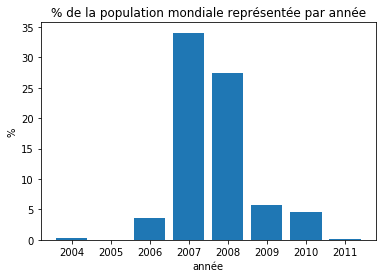

In [65]:
plt.bar(pop_annee.index, pop_annee['pop_rep (%)'])
plt.xlabel('année')
plt.ylabel('%')
plt.title('% de la population mondiale représentée par année')

plt.savefig('fig2.jpeg')

#### Part de la population mondiale représentée : 

##### En prenant les données de pop : 

Je prends l'année 2007, comme année de référence puisque c'est l'année qui est la mieux représentée. 

In [66]:
prop_pop_rep = pop_annee.pop_rep.sum() / pop_annee[pop_annee.index == 2007]['population'] * 100
print(prop_pop_rep)
print(f'Total population représentée : {int(pop_annee.pop_rep.sum()):,}')

year
2007    76.279316
Name: population, dtype: float64
Total population représentée : 6,165,056,182


Environ 76% de la population mondiale recensée par la FAO en 2007 est représentée. 

## Type des quantiles

In [302]:
# Rappel
inc4.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0


Il y a 100 quantiles par pays. Il s'agit donc de [centiles](https://fr.wikipedia.org/wiki/Centile).  
Échantillonner une population en utilisant des quantiles est selon moi une bonne méthode car cela permet ensuite de **pouvoir faire des comparaisons** à l'intérieur d'une population et bien sûr entre populations différentes, en fonction de ces quantiles. C'est d'ailleurs l'exemple donné sur Wikipedia :  
"Si on regarde la répartition des revenus de la population, on pourra par exemple calculer « le revenu moyen du dernier décile (ou des dix derniers centiles) », soit le revenu moyen des 10 % de gens qui gagnent le plus, et « le seuil de revenu correspondant au 90e centile, au 95e centile », soit le revenu que gagne la personne la moins riche parmi les 10 % ou les 5 % des plus riches. Le 50e centile représente quant à lui le salaire médian."

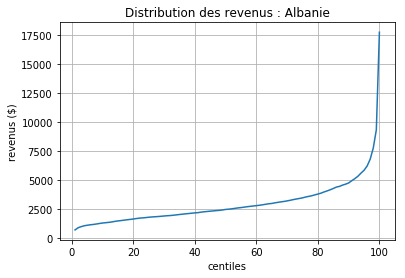

In [308]:
# Exemple de représentation de la distribution des revenus pour un pays
rep_cent = inc4.loc[inc4.country_code == 'ALB', ['income', 'quantile']]
plt.plot(rep_cent['quantile'], rep_cent['income'])
plt.title('Distribution des revenus : Albanie')
plt.xlabel('centiles')
plt.ylabel('revenus ($)')
plt.grid()

plt.savefig('fig3.jpeg')

---

<a id='Mission2'></a>

[Haut de page](#Top) 

# <font color='#FFCA36'>Mission 2</font>

1. Montrer la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.  

- Représenter la courbe de Lorenz de chacun des pays choisis  

- Pour chacun de ces pays, représenter l'évolution de l'indice de Gini au fil des ans.  

- Classer les pays par indice de Gini. Donner la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

<a id='Diversite'></a>

## 1. Diversité des pays en termes de distribution de revenus

### Choix des pays

In [309]:
# Je créé un df pour avoir la moyenne des revenus par pays, je le classe par income
inc_dr  = inc4.groupby(['country_name', 'country_code'])['income'].mean().reset_index()
inc_dr.sort_values('income').head()

,country_name,country_code,income
23,Congo République démocratique du,COD,276.016044
64,Madagascar,MDG,345.237074
27,Côte d'Ivoire,CIV,399.835204
56,Kenya,KEN,519.320032
102,Swaziland,SWZ,530.283828


In [310]:
inc_dr.sort_values('income').tail()

,country_name,country_code,income
78,Norvège,NOR,22483.375020
18,Canada,CAN,23739.640518
62,Luxembourg,LUX,25217.562681
115,États-Unis d'Amérique,USA,25503.581661
50,Islande,ISL,26888.511518


=> les 2 1ers pays que je choisis sont ceux qui sont aux extrêmes : le Congo et l'Islande.

Je choisis les autres pays en fonction des quartiles obtenus via describe()

In [311]:
inc_dr.describe()

,income
count,116.000000
mean,6069.121925
std,6660.966925
min,276.016044
25%,1374.270126
50%,3287.174692
75%,7077.900152
max,26888.511518


In [387]:
inc_dr[(inc_dr.income > 1370) & (inc_dr.income < 1380)]

,country_name,country,income
111,Viet Nam,VNM,1377.773966


In [313]:
inc_dr[(inc_dr.income > 3270) & (inc_dr.income < 3290)]

,country_name,country_code,income
83,Paraguay,PRY,3278.080965


In [314]:
inc_dr[(inc_dr.income > 7050) & (inc_dr.income < 7100)]

,country_name,country_code,income
19,Chili,CHL,7051.609966


Et enfin, je choisis aussi la France pour avoir un point de comparaison que je connais. 

In [315]:
inc_dr[inc_dr.country_name == 'France']

,country_name,country_code,income
36,France,FRA,18309.407545


Je choisis donc **6 pays**:
- République démocratique du Congo COD (income = 276) et l'Islande ISL (26888), les 2 pays aux extrémités de la liste.
- Vien Nam VNM 1378
- Paraguay PRY 3278
- Chili CHL 7051
- France FRA 18309

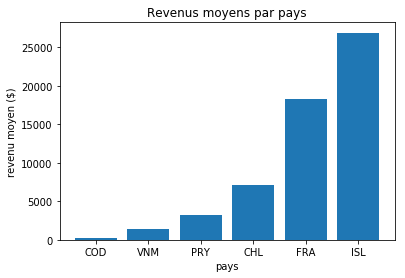

In [320]:
# Représentation des revenus moyens par pays choisi
inc_dr_graph = inc_dr[(inc_dr.country_code == 'FRA') |
                     (inc_dr.country_code == 'COD') |
                     (inc_dr.country_code == 'VNM') |
                     (inc_dr.country_code == 'PRY') |
                     (inc_dr.country_code == 'CHL') |
                     (inc_dr.country_code == 'ISL')].sort_values('income')

plt.bar(inc_dr_graph.country_code, inc_dr_graph.income)
plt.xlabel('pays')
plt.ylabel('revenu moyen ($)')
plt.title('Revenus moyens par pays')

plt.savefig('fig4.jpeg')

### Représentation du revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus des pays choisis

In [322]:
inc4.head() 

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0


In [427]:
# Pour plus de facilité, je renomme la RDC en "Congo"
inc4.loc[inc4.country_code == 'COD', 'country_name'] = 'Congo'

##### Représentation graphique

In [5]:
# Je créé une variable pour les codes pays
c_codes = ['FRA','COD', 'ISL', 'VNM', 'PRY', 'CHL']

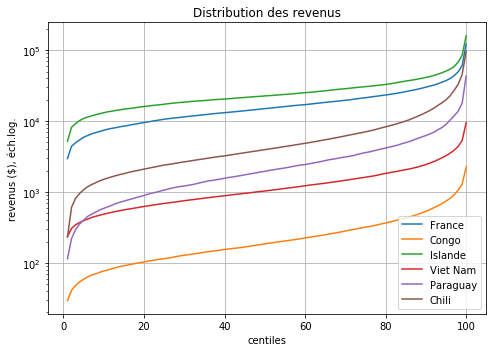

In [462]:
plt.figure(figsize=(7,5))
plt.grid()
plt.yscale('log')

for x in c_codes:
    # données sur lesquelles se baser
    data = inc4[inc4.country_code == x]
    # on retrouve les noms des pays
    pays = data.country_name.iloc[0] 
    plt.plot(data['quantile'], data['income'], label = pays)

plt.xlabel('centiles')
plt.ylabel('revenus ($), éch.log.')
plt.title('Distribution des revenus')
plt.tight_layout()
plt.legend()

plt.savefig('fig5.jpeg')

<a id='Lorenz'></a>

## 2. Courbe de Lorenz de chacun des pays choisis.

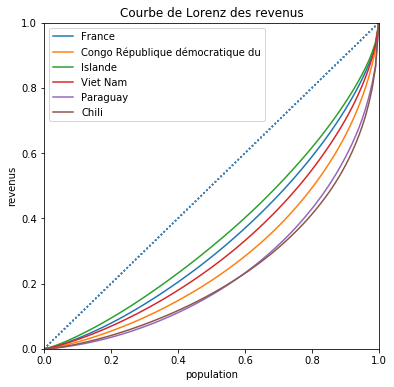

In [12]:
fig = plt.figure(figsize=(6, 6))

for x in c_codes:
    # données sur lesquelles se baser
    data = inc4[inc4.country_code == x]
    # on retrouve les noms des pays
    pays = data.country_name.iloc[0] 
    
    # calcul pour la courbe de Lorenz
    lorenz = np.cumsum(np.sort(data['income'])) / data['income'].sum()
    # La courbe de Lorenz commence à 0
    lorenz = np.append([0], lorenz) 
    plt.plot(np.linspace(0, 1, len(lorenz)), lorenz, label = pays)
    
    # diagonale
    plt.plot([0,1], [0,1], color='steelblue', linestyle = ':') 

plt.xlabel('population')
plt.ylabel('revenus')
plt.legend()

plt.ylim(0, 1)
plt.xlim(0, 1)

# plt.grid()

plt.title('Courbe de Lorenz des revenus')

plt.savefig('fig6.jpeg')

Les courbes les plus proches de la diagonale représentent les pays les plus égalitaires.  
Ici : l'Islande, suivie de la France. 

<a id='Gini'></a>

[Haut de page](#Top) 

## 3. Évolution de l'indice de Gini au fil des ans

Source : [Banque mondiale](https://data.worldbank.org/indicator/SI.POV.GINI) via Openclassrooms. 

In [2]:
# Import des indices de Gini
gini = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/indices_Gini.csv', skiprows=3)

In [53]:
gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
gini.shape

(264, 65)

264 pays/régions sont présents.

In [3]:
# Suppression des colonnes inutiles
gini.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 64'], inplace=True, axis = 1)

In [75]:
gini.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Représentation sur un seul axe (meilleure solution)

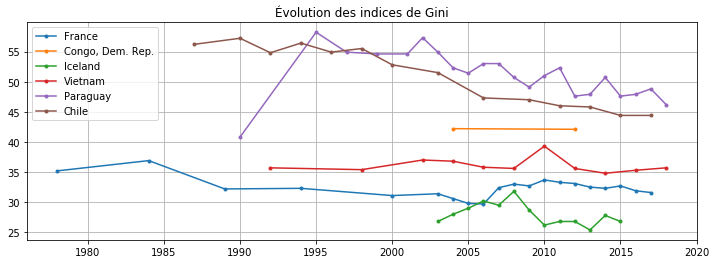

In [7]:
plt.figure(figsize=(12,4))

for x in c_codes:
    # df sur lequel on va se baser
    data_g = gini[gini['Country Code'] == x] 
    # on retrouve les noms de pays pour la légende
    pays = data_g['Country Name'].iloc[0] 
    
    data_g2 = (
        data_g
            .dropna(axis=1)
            .drop(['Country Name', 'Country Code'], axis=1)
    )
    
    # Définition des variables (sans astype, l'affichage devient problématique)
    annees = pd.Series(data_g2.columns.to_list()).astype(int) 
    ind_gini = pd.Series(data_g2.iloc[0].to_list())
    
    plt.plot(annees, ind_gini, label = pays, marker = '.')

plt.grid()
plt.legend()
plt.title('Évolution des indices de Gini')

plt.savefig('fig7.jpeg')

#### Représentation sur plusieurs axes

##### 1ère solution

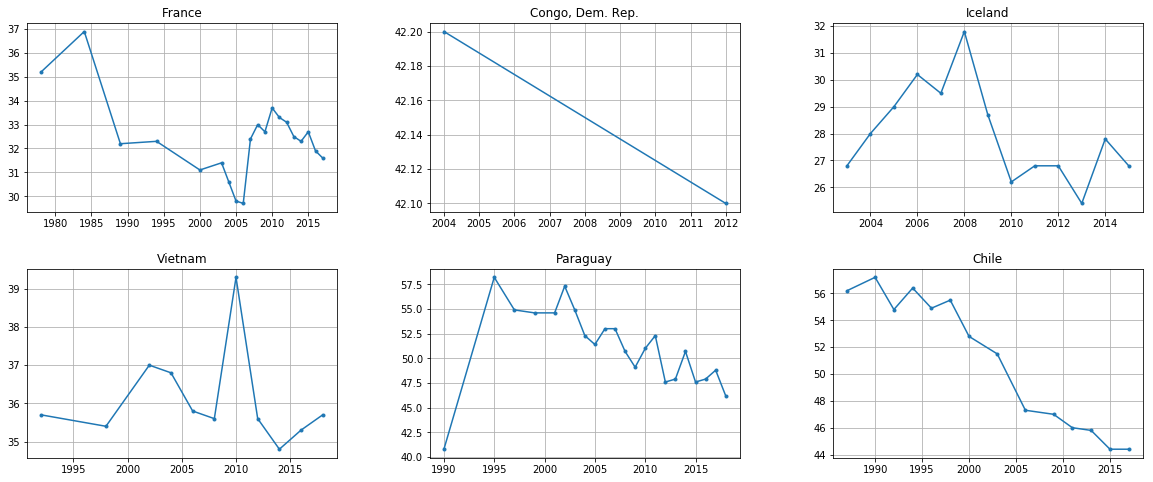

In [112]:
plt.figure(figsize=(20,8))

plt.title('Évolution des indices de Gini de 5 pays')

for i, x in enumerate(c_codes):
    # df sur lequel on va se baser
    data_g = gini[gini['Country Code'] == x]
    # on retrouve les noms de pays pour la légende
    pays = data_g['Country Name'].iloc[0] 
    
    data_g2 = (
        data_g
            .dropna(axis=1)
            .drop(['Country Name', 'Country Code'], axis=1)
    )
    
    annees = pd.Series(data_g2.columns.to_list()).astype(int) # sans astype, l'affichage devient problématique
    ind_gini = pd.Series(data_g2.iloc[0].to_list())
    
    ax = plt.subplot(2,3,i+1)
    plt.plot(annees, ind_gini, label = pays, marker = '.')
    plt.title(pays)
    plt.grid()

plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.savefig('fig8.jpeg')

##### 2ème solution pour voir (mais sans doute moins "pythonique")

In [83]:
gini.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
gini2 = gini.drop('Country Code', axis = 1)

In [87]:
gini2.set_index('Country Name', inplace = True)

In [88]:
# Recherche des pays choisis :
gini_FRA  = gini2[gini2.index=='France']
gini_FRA.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.2,NaN,NaN,NaN,NaN,NaN,36.9,NaN,NaN,NaN,NaN,32.2,NaN,NaN,NaN,NaN,32.3,NaN,NaN,NaN,NaN,NaN,31.1,NaN,NaN,31.4,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3,33.1,32.5,32.3,32.7,31.9,31.6,NaN,NaN


In [89]:
gini_COD = gini2[gini2.index=='Congo, Dem. Rep.']
gini_COD.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Congo, Dem. Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
gini2[gini2.index=='Congo, Dem. Rep.']

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Congo, Dem. Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
gini_ISL = gini2[gini2.index=='Iceland']
gini_ISL.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iceland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8,28.0,29.0,30.2,29.5,31.8,28.7,26.2,26.8,26.8,25.4,27.8,26.8,NaN,NaN,NaN,NaN


In [92]:
gini_VNM = gini2[gini2.index=='Vietnam']
gini_VNM.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Vietnam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.7,NaN,NaN,NaN,NaN,NaN,35.4,NaN,NaN,NaN,37.0,NaN,36.8,NaN,35.8,NaN,35.6,NaN,39.3,NaN,35.6,NaN,34.8,NaN,35.3,NaN,35.7,NaN


In [93]:
gini_PRY = gini2[gini2.index=='Paraguay']
gini_PRY.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Paraguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.8,NaN,NaN,NaN,NaN,58.2,NaN,54.9,NaN,54.6,NaN,54.6,57.3,54.9,52.3,51.4,53.0,53.0,50.7,49.1,51.0,52.3,47.6,47.9,50.7,47.6,47.9,48.8,46.2,NaN


In [94]:
gini_CHL = gini2[gini2.index=='Chile']
gini_CHL.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Chile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.2,NaN,NaN,57.2,NaN,54.8,NaN,56.4,NaN,54.9,NaN,55.5,NaN,52.8,NaN,NaN,51.5,NaN,NaN,47.3,NaN,NaN,47.0,NaN,46.0,NaN,45.8,NaN,44.4,NaN,44.4,NaN,NaN


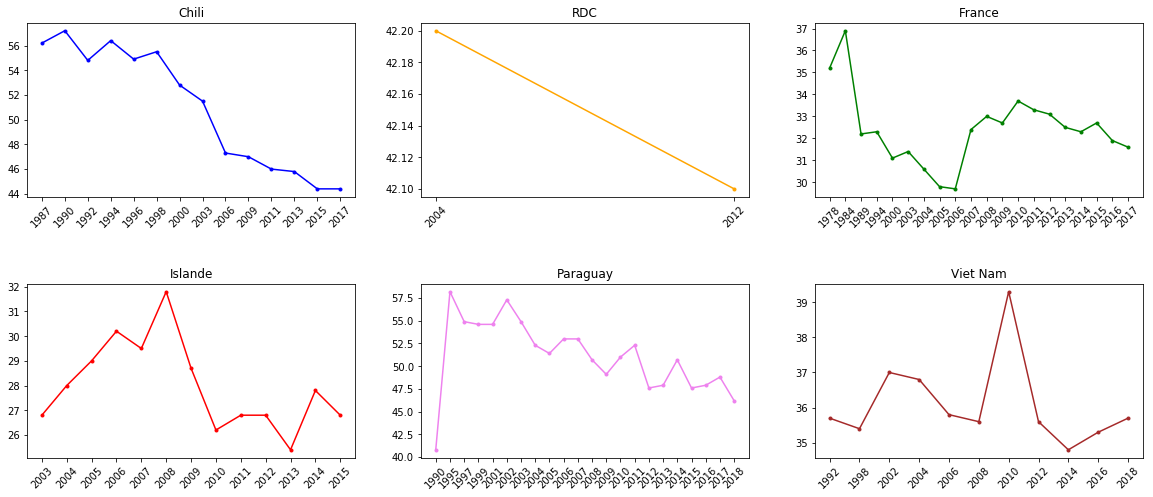

In [109]:
plt.figure(figsize=(20, 8))
plt.subplots_adjust(hspace = 0.5)

plt.subplot(231)
plt.plot(gini_CHL.T.dropna(axis=0).index, gini_CHL.T.dropna(axis=0), marker = '.', color = 'blue')
plt.xticks(rotation = 45)
plt.title('Chili')

plt.subplot(232)
plt.plot(gini_COD.T.dropna(axis=0).index, gini_COD.T.dropna(axis=0), marker = '.', color = 'orange')
plt.xticks(rotation = 45)
plt.title('RDC')

plt.subplot(233)
plt.plot(gini_FRA.T.dropna(axis=0).index, gini_FRA.T.dropna(axis=0), marker = '.', color = 'green')
plt.xticks(rotation = 45)
plt.title('France')

plt.subplot(234)
plt.plot(gini_ISL.T.dropna(axis=0).index, gini_ISL.T.dropna(axis=0), marker = '.', color = 'r')
plt.xticks(rotation = 45)
plt.title('Islande')

plt.subplot(235)
plt.plot(gini_PRY.T.dropna(axis=0).index, gini_PRY.T.dropna(axis=0), marker = '.', color = 'violet')
plt.xticks(rotation = 45)
plt.title('Paraguay')

plt.subplot(236)
plt.plot(gini_VNM.T.dropna(axis=0).index, gini_VNM.T.dropna(axis=0), marker = '.', color = 'brown')
plt.xticks(rotation = 45)
plt.title('Viet Nam')

plt.savefig('fig9.jpeg')

<a id='PaysGini'></a>

[Haut de page](#Top) 

## 4. Pays par indice de Gini

In [2]:
# Je commence pa récupérer le df avec les indices
gini3 = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/indices_Gini.csv', skiprows=3)

In [18]:
gini3.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
gini3.shape

(264, 65)

In [20]:
# Suppression des colonnes inutiles
gini3.drop(['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 64'], inplace=True, axis = 1)

In [154]:
gini3.head()

,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On constate que l'indice de Gini est exprimé en %. 

In [3]:
# Calcul des moyennes des indices pour chaque pays
gini3['mean_gini'] = gini3.mean(axis=1)

In [4]:
# Je garde les colonnes utiles
gini3 = gini3[['Country Code', 'mean_gini']]

In [5]:
gini3.head()

,Country Code,mean_gini
0,ABW,NaN
1,AFG,NaN
2,AGO,48.666667
3,ALB,31.411111
4,AND,NaN


In [24]:
gini3.shape

(264, 2)

In [115]:
gini3.isnull().sum()

Country Code     0
mean_gini       99
dtype: int64

In [25]:
# Je reprends le df de base et j'en fais une copie
inc4g = inc4.copy()

In [105]:
inc4g.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country_name    0
population      0
dtype: int64

In [182]:
# Pour mémoire
inc4g.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0


In [26]:
# Jointure pour ajouter la moyenne de l'indice de Gini par pays
inc4g = pd.merge(inc4g, gini3, left_on = 'country_code', right_on = 'Country Code', how = 'left')
inc4g.drop('Country Code', axis = 1, inplace = True)

In [27]:
inc4g.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0,31.411111
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0,31.411111
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0,31.411111
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0,31.411111
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0,31.411111


In [28]:
inc4g.isnull().sum()

country_code      0
year              0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
country_name      0
population        0
mean_gini       200
dtype: int64

2 pays n'ont pas d'indice de Gini. Voyons lesquels. 

In [29]:
inc4g[inc4g.mean_gini.isnull()].groupby('country_name').nunique()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini
country_name,,,,,,,,,
Cambodge,1,1,100,1,100,1,1,1,1
Taiwan,1,1,100,1,100,1,1,1,1


Je ne trouve pas d'indice concernant ces pays sur le site de la BM. Je ne peux pas m'assurer de la fiabilité des autres sources (wikipedia par exemple). Je décide de supprimer ces lignes.

In [193]:
inc4g[inc4g.country_name == 'Cambodge'].head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini
5600,KHM,2008,1,100,345.87497,1802.0,Cambodge,13883833.0,NaN
5601,KHM,2008,2,100,437.74557,1802.0,Cambodge,13883833.0,NaN
5602,KHM,2008,3,100,481.92444,1802.0,Cambodge,13883833.0,NaN
5603,KHM,2008,4,100,514.47370,1802.0,Cambodge,13883833.0,NaN
5604,KHM,2008,5,100,540.41986,1802.0,Cambodge,13883833.0,NaN


In [154]:
inc4g = inc4g[~inc4g.mean_gini.isnull()]

In [157]:
inc4g.shape

(11400, 9)

In [159]:
inc4g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11400 entries, 0 to 11599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  11400 non-null  object 
 1   year          11400 non-null  int64  
 2   quantile      11400 non-null  int64  
 3   nb_quantiles  11400 non-null  int64  
 4   income        11400 non-null  float64
 5   gdpppp        11400 non-null  float64
 6   country_name  11400 non-null  object 
 7   population    11400 non-null  float64
 8   mean_gini     11400 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 890.6+ KB


In [160]:
# Enregistrement du df
inc4g.to_csv('C:/Users/Zang/Documents/APPRENDER/OPENCLASSROOMS/PARCOURS DA/P7_Effectuez_une_prediction_de_revenus/donnees/inc4g.csv', index=False)

In [42]:
# Import
inc4g = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/inc4g.csv')

In [6]:
inc4g.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0,31.411111
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0,31.411111
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0,31.411111
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0,31.411111
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0,31.411111


##### Moyenne mondiale de l'indice de Gini

In [11]:
# On fait un mean sur la colonne
inc4g['mean_gini'].mean()

38.19250125121085

Nous allons visualiser la distribution des indices de Gini sur un histogramme. 

In [27]:
# group by pays via mean
mean_gini_w = (inc4g[['country_code','country_name', 'mean_gini']]
 .groupby('country_name')
 .mean())
mean_gini_w.head(2)

,mean_gini
country_name,
Afrique du Sud,61.714286
Albanie,31.411111


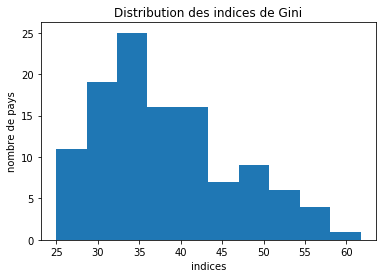

In [41]:
plt.hist(mean_gini_w.mean_gini, bins = 10)
plt.title('Distribution des indices de Gini')
plt.xlabel('indices')
plt.ylabel('nombre de pays');

##### Indices de Gini les plus hauts (pays les plus inégalitaires)

In [164]:
# group by pays, moyenne puis classement
(inc4g[['country_code','country_name', 'mean_gini']]
 .groupby('country_name')
 .mean()
 .sort_values('mean_gini', ascending = False)
 .head())

,mean_gini
country_name,
Afrique du Sud,61.714286
Brésil,56.847059
Guatemala,55.000000
Swaziland,54.925000
Honduras,54.641379


##### Indices de Gini les plus bas (pays les plus égalitaires)

In [163]:
(inc4g[['country_code','country_name', 'mean_gini']]
 .groupby('country_name')
 .mean()
 .sort_values('mean_gini')
 .head())

,mean_gini
country_name,
Slovénie,24.961111
République tchèque,25.944444
Slovaquie,26.160000
Danemark,26.405263
Finlande,26.768421


##### Où se situe la France ? 

In [12]:
F_gini = (inc4g[['country_code','country_name', 'mean_gini']]
 .groupby('country_name')
 .mean()
 .sort_values('mean_gini'))
F_gini.reset_index(inplace=True)
F_gini.head()

,country_name,mean_gini
0,Slovénie,24.961111
1,République tchèque,25.944444
2,Slovaquie,26.160000
3,Danemark,26.405263
4,Finlande,26.768421


In [13]:
F_gini[F_gini.country_name == 'France']

,country_name,mean_gini
31,France,32.42


In [166]:
place_F = F_gini[F_gini.country_name == 'France'].index[0]
place_F + 1

32

In [167]:
len(F_gini)

114

In [169]:
print(f'Concernant l\'indice de Gini, la France est à la place n°{place_F + 1} sur {len(F_gini)} pays')

Concernant l'indice de Gini, la France est à la place n°32 sur 114 pays


<a id='Mission3'></a>

[Haut de page](#Top) 

# <font color='#FFCA36'>Mission 3</font>

# Calcul de la classe des revenus des parents

<a id='elasticite'></a>

## Coefficients d'élasticité

Méthodo suivie : application du coef du pays quand il est connu (précis), sinon application du coef de la région (moins précis).

In [29]:
# import des coef. d'elasticité. Source Banque mondiale via Openclassrooms
coelast = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/GDIMMay2018.csv')

In [30]:
coelast.head(2)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,cohort,parent,child,obs,P1,P2,P3,P4,P5,C1,C2,C3,C4,C5,MEANp,MEANc,SDp,SDc,GINIp,GINIc,IGP,NL1,NL2,COR,MAcatM,MAcatC1,Q4_IGpri,BHQ1,BHQ2,BHQ3,BHQ4,Q4BH,Q4child,Delta50,Asher_Q4_IGpri,ThreeGen_obs,ThreeGen_IGPp1,ThreeGen_IGPg1,ThreeGen_IGPgsd,All2125_MEANp,All2125_MEANc,All2125_IGP,All2125_MAcatC1,Cores2125_MEANp,Cores2125_MEANc,Cores2125_IGP,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,all,3956.0,0.666125,0.098583,0.170931,0.043031,0.021330,0.511857,0.025805,0.164191,0.183469,0.114678,2.480162,5.582401,3.809782,5.857765,0.728547,0.569981,0.802107,1.078013,-0.025322,0.521676,0.416691,0.414355,0.573748,0.341912,0.325161,0.209395,0.123532,0.162255,0.250311,3.408008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,daughter,721.0,0.615321,0.099272,0.212776,0.051969,0.020662,0.628481,0.023378,0.099265,0.132322,0.116553,2.989992,4.331731,4.010379,5.902685,0.675526,0.681604,0.848156,0.904866,-0.005200,0.576251,0.284895,0.283075,0.493111,0.434127,0.390918,0.101283,0.073671,0.285185,0.214735,1.859528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1


In [31]:
# Je ne conserve que les colonnes utiles
coelast = coelast[['countryname', 'iso3', 'region', 'incgroup4', 'IGEincome']]

In [32]:
coelast.head(1)

,countryname,iso3,region,incgroup4,IGEincome
0,Afghanistan,AFG,South Asia,Low income,NaN


In [33]:
coelast.shape

(6504, 5)

In [34]:
# Je fais un groupby pour avoir le coef par pays (le coef est unique par pays, on peut faire un mean, un min ou un max)
coelast_country = coelast.groupby(['iso3', 'region', 'incgroup4']).mean().reset_index()

In [35]:
coelast_country.shape

(150, 4)

In [36]:
coelast_country.head()

,iso3,region,incgroup4,IGEincome
0,AFG,South Asia,Low income,NaN
1,AGO,Sub-Saharan Africa,Upper middle income,NaN
2,ALB,Europe & Central Asia,Upper middle income,0.815874
3,ARG,Latin America & Caribbean,Upper middle income,NaN
4,ARM,Europe & Central Asia,Lower middle income,NaN


In [37]:
# Un 2d groupby permet d'avoir les coef par région
coelast_region = coelast_country.groupby(['region','incgroup4']).mean().reset_index()

In [38]:
coelast_region

,region,incgroup4,IGEincome
0,East Asia & Pacific,Lower middle income,0.527665
1,East Asia & Pacific,Upper middle income,0.469500
2,Europe & Central Asia,Lower middle income,0.424817
3,Europe & Central Asia,Upper middle income,0.477171
4,High income,High income,0.346163
5,Latin America & Caribbean,Lower middle income,0.940737
6,Latin America & Caribbean,Upper middle income,0.878852
7,Middle East & North Africa,Lower middle income,0.916461
8,Middle East & North Africa,Upper middle income,0.517398
9,South Asia,Low income,0.436000


In [180]:
# [Inutile...] Je remplace le coef NaN par 0.4 (cf. fichier .txt "elasticity")
# coelast_region.loc[coelast_region['IGEincome'].isnull(),'IGEincome'] = 0.4

In [39]:
# Jointure entre coelast_gb et coelast_gb2 pour avoir les coef par pays (suffixe c) et par région (suffixe r)
coelast2 = (coelast_country
            .merge(coelast_region, left_on=['region','incgroup4'], right_on=['region','incgroup4'], suffixes = ('_c', '_r')))
coelast2.head()

,iso3,region,incgroup4,IGEincome_c,IGEincome_r
0,AFG,South Asia,Low income,NaN,0.436
1,NPL,South Asia,Low income,0.436,0.436
2,AGO,Sub-Saharan Africa,Upper middle income,NaN,0.677
3,BWA,Sub-Saharan Africa,Upper middle income,NaN,0.677
4,GAB,Sub-Saharan Africa,Upper middle income,NaN,0.677


In [40]:
# Vérification
coelast2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso3         150 non-null    object 
 1   region       150 non-null    object 
 2   incgroup4    150 non-null    object 
 3   IGEincome_c  75 non-null     float64
 4   IGEincome_r  149 non-null    float64
dtypes: float64(2), object(3)
memory usage: 7.0+ KB


75 pays n'ont pas de coef. 

In [41]:
# On va remplacer les données manquantes dans IGEincome_c
coelast2.loc[coelast2['IGEincome_c'].isnull(),'IGEincome_c'] = coelast2.loc[coelast2['IGEincome_c'].isnull(),'IGEincome_r']

In [42]:
# Vérification
coelast2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso3         150 non-null    object 
 1   region       150 non-null    object 
 2   incgroup4    150 non-null    object 
 3   IGEincome_c  149 non-null    float64
 4   IGEincome_r  149 non-null    float64
dtypes: float64(2), object(3)
memory usage: 7.0+ KB


In [43]:
coelast2.head(20)

,iso3,region,incgroup4,IGEincome_c,IGEincome_r
0,AFG,South Asia,Low income,0.436000,0.436000
1,NPL,South Asia,Low income,0.436000,0.436000
2,AGO,Sub-Saharan Africa,Upper middle income,0.677000,0.677000
3,BWA,Sub-Saharan Africa,Upper middle income,0.677000,0.677000
4,GAB,Sub-Saharan Africa,Upper middle income,0.677000,0.677000
5,MUS,Sub-Saharan Africa,Upper middle income,0.677000,0.677000
6,NAM,Sub-Saharan Africa,Upper middle income,0.677000,0.677000
7,ZAF,Sub-Saharan Africa,Upper middle income,0.677000,0.677000
8,ALB,Europe & Central Asia,Upper middle income,0.815874,0.477171
9,AZE,Europe & Central Asia,Upper middle income,0.477171,0.477171


In [44]:
# Je ne garde que les colonnes utiles
coelast2 = coelast2[['iso3', 'region', 'incgroup4', 'IGEincome_c']]

In [47]:
# Pour mémoire
inc4g.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0,31.411111
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0,31.411111
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,3002678.0,31.411111
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,3002678.0,31.411111
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,3002678.0,31.411111


In [48]:
# Jointure avec le df global pour avoir le coef d'élasticité
inc5 = inc4g.merge(coelast2, how = 'left', left_on = 'country_code', right_on = 'iso3')

In [49]:
inc5.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_name,population,mean_gini,iso3,region,incgroup4,IGEincome_c
0,ALB,2008,1,100,728.89795,7297.0,Albanie,3002678.0,31.411111,ALB,Europe & Central Asia,Upper middle income,0.815874
1,ALB,2008,2,100,916.66235,7297.0,Albanie,3002678.0,31.411111,ALB,Europe & Central Asia,Upper middle income,0.815874


In [50]:
# Je ne garde que les colonnes utiles
inc5 = inc5[['country_code', 'quantile', 'nb_quantiles', 'income', 'gdpppp', 'mean_gini', 'IGEincome_c']]

In [51]:
# Je renomme la colonne pour plus de clarté
inc5.rename(columns = {'IGEincome_c' : 'coef_elast'}, inplace=True)

In [52]:
inc5.head()

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast
0,ALB,1,100,728.89795,7297.0,31.411111,0.815874
1,ALB,2,100,916.66235,7297.0,31.411111,0.815874
2,ALB,3,100,1010.91600,7297.0,31.411111,0.815874
3,ALB,4,100,1086.90780,7297.0,31.411111,0.815874
4,ALB,5,100,1132.69970,7297.0,31.411111,0.815874


In [53]:
inc5.isnull().sum()

country_code      0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
mean_gini         0
coef_elast      200
dtype: int64

2 pays n'ont pas de coef d'élasticité. Voyons lesquels. 

In [54]:
inc5[inc5['coef_elast'].isnull()].groupby('country_code').nunique()

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast
country_code,,,,,,,
SYR,1,100,1,100,1,1,1
XKX,1,100,1,100,1,1,1


In [216]:
coelast2[coelast2.iso3=='XKX']

,iso3,region,incgroup4,IGEincome_c


In [217]:
coelast2[coelast2.iso3=='SYR']

,iso3,region,incgroup4,IGEincome_c


N'ayant pas trouvé de source d'info sure, je préfère ne pas remplacer par des valeurs sujettes à caution. 

In [218]:
# Je conserve tout les autres lignes
inc5 = inc5[~inc5.coef_elast.isnull()]

In [176]:
# Enregistrement
inc5.to_csv('C:/Users/Zang/Documents/APPRENDER/OPENCLASSROOMS/PARCOURS DA/P7_Effectuez_une_prediction_de_revenus/donnees/inc_coelast.csv', index=False)

In [219]:
inc5.shape

(11200, 7)

In [8]:
# Import
inc5 = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/inc_coelast.csv')

In [3]:
inc5.shape

(11200, 7)

In [4]:
inc5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  11200 non-null  object 
 1   quantile      11200 non-null  int64  
 2   nb_quantiles  11200 non-null  int64  
 3   income        11200 non-null  float64
 4   gdpppp        11200 non-null  float64
 5   mean_gini     11200 non-null  float64
 6   coef_elast    11200 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 612.6+ KB


<a id='classeparents'></a>

[Haut de page](#Top) 

## Génération de la classe de revenu des parents

### Étapes 1 à 5

In [16]:
inc5.head(2)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171
1,ALB,2,100,916.66235,7297.0,31.411111,0.477171


In [9]:
# Vérification du coef de la France
inc5[inc5.country_code == 'FRA']['coef_elast'].unique()

array([0.34616334])

In [2]:
from collections import Counter

In [17]:
# Cette fonction est utilisée pour les étapes 1, 2 , 3. Elle renvoie n salaire d'enfants et les n salaires de parents 
# respectifs

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (sur le calcul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size = n)
    # Génération d'une réalisation du terme d'erreur epsilon (selon la loi Normale)
    epsilon = st.norm(0,1).rvs(size = n)
    # On calcule le salaire des enfant en fonction de la fonction linéaire et de l'indice d'élasticité pj
    return np.exp(pj * ln_y_parent + epsilon), np.exp(ln_y_parent)

In [18]:
# Fonction utilisée dans la fonction qui suit juste après : compute_quantiles()
# Fonction qui prend en paramètre une serie l et un nb_quantile et renvoie une série indiquant le quantile qui correspond 
# à chaque valeur de l. Elle créé un array composés de l éléments auxquels est associé un chiffre entre 1 et nb_quantiles

def quantiles(l, nb_quantiles):
    size = len(l)
    # Tri des valeurs de l
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    # Pour identifier le quantile de chaque indice
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    # On associe les quantiles aux y_child, y_parents...sous forme de dictionnaire...
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    # ...et le renvoie sous forme de series
    return pd.Series([q_dict[e] for e in l])


# Pour l'étape 4 :
# Fonction qui prend en parametre un array de revenus d'enfants, un autre de parents et un nombre de quantiles.
# Elle renvoie un df avec en colonnes y_child | y_parents | c_i_child | c_i_parents

def compute_quantiles(y_child, y_parents, nb_quantiles):
    # Transformation en séries des revenus des parents et des enfants
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    # Calcul des quantiles des parents/enfants
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    # Colonnes mises côte à côte pour faire un dataframe
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis = 1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample


# Fonction utilisée uniquement dans conditional_distributions(), étape 5
# Elle prend en parametre le dataframe counts : c_i_child | c_i_parent | counts pour une classe enfant fixée 
# (c_i_child aura toujours la meme valeur)
# c_i_parent spécifie la classe du parent et counts le nb d'individus qui ont ce couple (classe enfant/classe parent)
# Elle renvoie la distribution des classes de revenu du parent pour la classe d'enfant
# sour la forme d'un array à 1 dimension avec i  +1 comme classe du parent

def distribution(counts, nb_quantiles):
    distrib = []
    # nombre total d'individus
    total = counts["counts"].sum()
    # si ce nb = 0, on renvoie une ligne de 0
    if total == 0 :
        return [0] * nb_quantiles
    
    # pour chaque quantile parent
    for q_p in range(1, nb_quantiles + 1):
        # on ne garde que les lignes du quantile parent en cours
        subset = counts[counts.c_i_parent == q_p]
        # si la longueur n'est pas nulle
        if len(subset):
            # on ajoute au resultat la fréquence d'apparition du quantile parent
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   


# Pour l'étape 5 :
# prend en parametre le dataframe sample y_child | y_parents | c_i_child | c_i_parents et le nombre de quantiles
# Renvoie une matrice a 2D :
# - une ligne par quantile enfant
# - au sein d'une ligne, on a la distribution des quantiles des parents
# les valeurs peuvent être interprétées comme des probabilités 'c_parent sachant c_enfant'

def conditional_distributions(sample, nb_quantiles):
    # On compte le nombre d'individu (couple parent/enfant) qu'il y a pour chaque paire de quantiles parent / enfant
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    # pour chaque child_quantile entre 1 et 100
    for child_quantile in np.arange(nb_quantiles) + 1:
        # on recupere les individus ou les enfants sont dans ce quantile
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

In [19]:
# Pour l'étape 6 : p est le coefficient d'élasticité, cd la matrice des distributions conditionnelles
def plot_conditional_distributions(p, cd, nb_quantiles): 
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : 
    # https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles) + 1, child_quantile, bottom = cumul, width = 0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)
        
    # Il est possible de retirer * 1.3 de la ligne suivante si pas de légende
    plt.axis([.5, nb_quantiles * 1.3, 0, 1])
    plt.title("indice d'élasticité p = " + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.tight_layout()
    # plt.show()
    
# Cette fonction donne les probabilités P(ci,parent|ci,child, j)    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

### Etape 6. Vérification de la cohérence du code

##### Représentation avec nb_quantiles = 100

[[0.068 0.044 0.043 ... 0.002 0.    0.002]
 [0.041 0.025 0.028 ... 0.003 0.002 0.   ]
 [0.037 0.031 0.021 ... 0.    0.001 0.   ]
 ...
 [0.001 0.    0.003 ... 0.041 0.036 0.038]
 [0.001 0.003 0.003 ... 0.035 0.032 0.034]
 [0.    0.001 0.    ... 0.037 0.037 0.068]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.34) = 0.012
Wall time: 18.3 s


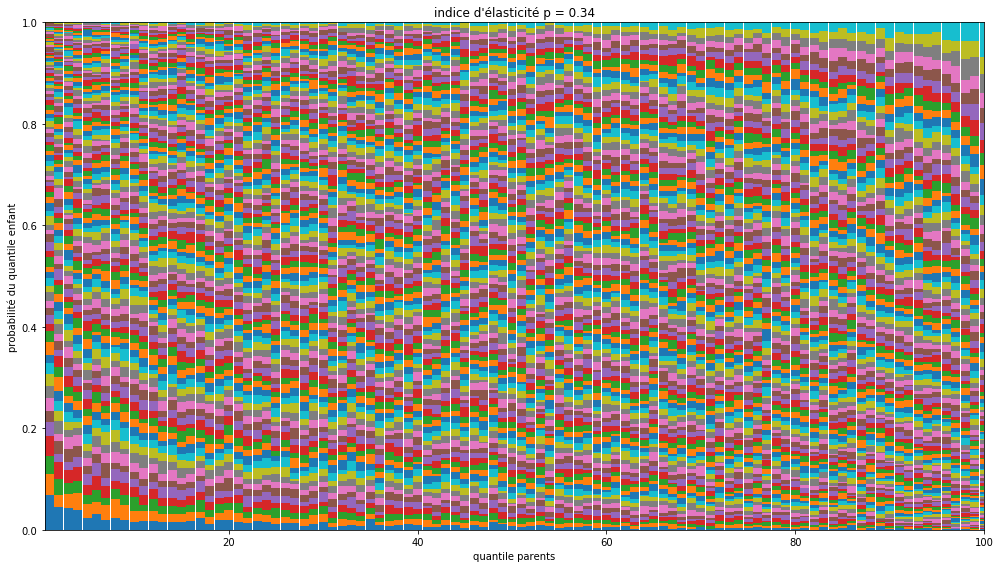

In [16]:
%%time

# Définition des paramètres : 

# coefficient d'élasticité du pays que je souhaite étudier (p est le coef, j le pays - voir generate_incomes)
# France
pj = 0.34 
# nombre de quantiles (nombre de classes de revenu)
nb_quantiles = 100 
# taille de l'échantillon
n = 1000 * nb_quantiles 

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
# Cette instruction prendra du temps si nb_quantiles > 10
plot_conditional_distributions(pj, cd, nb_quantiles)  
print(cd)

# Classe de revenu de l'enfant
c_i_child = 5
# Classe de revenu du parent
c_i_parent = 8
# Proba de la classe parent connaissant la classe enfant (cd étant la distribution conditionnelle)
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))

generate_incomes(n,pj)

plt.savefig('fig10-1.jpeg')

##### Représentation avec nb_quantiles = 10 et pj = 0.34 (France)

[[0.213 0.176 0.141 0.109 0.093 0.091 0.063 0.056 0.039 0.019]
 [0.172 0.12  0.14  0.104 0.104 0.098 0.082 0.074 0.055 0.051]
 [0.109 0.122 0.119 0.121 0.117 0.094 0.095 0.087 0.082 0.054]
 [0.115 0.115 0.122 0.109 0.111 0.106 0.088 0.1   0.067 0.067]
 [0.09  0.101 0.107 0.106 0.106 0.1   0.109 0.096 0.101 0.084]
 [0.09  0.092 0.092 0.106 0.098 0.096 0.112 0.112 0.117 0.085]
 [0.073 0.082 0.093 0.091 0.101 0.099 0.108 0.118 0.128 0.107]
 [0.063 0.079 0.066 0.098 0.088 0.096 0.101 0.129 0.141 0.139]
 [0.045 0.07  0.071 0.086 0.094 0.12  0.122 0.107 0.132 0.153]
 [0.03  0.043 0.049 0.07  0.088 0.1   0.12  0.121 0.138 0.241]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.34) = 0.117
Wall time: 298 ms


(array([1.50538994, 3.38148569, 0.59749397, ..., 5.95791326, 0.57534194,
        2.74772849]),
 array([1.36098892, 0.45134458, 0.21872547, ..., 0.79905859, 0.08685796,
        1.57573621]))

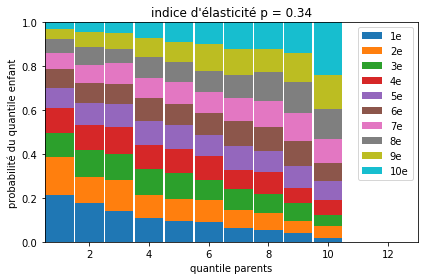

In [21]:
%%time

# coefficient d'élasticité du pays que je souhaite étudier (p est le coef, j le pays - voir generate_incomes)
# France
pj = 0.34 
# nombre de quantiles (nombre de classes de revenu)
nb_quantiles = 10 
# taille de l'échantillon
n = 1000 * nb_quantiles 

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
# Cette instruction prendra du temps si nb_quantiles > 10
plot_conditional_distributions(pj, cd, nb_quantiles) 
print(cd)

# Classe de revenu de l'enfant
c_i_child = 5
# Classe de revenu du parent
c_i_parent = 8
# Proba de la classe parent connaissant la classe enfant (cd étant la distribution conditionnelle)
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

generate_incomes(n,pj)

# plt.savefig('fig11-1.jpeg')

On observe une mobilité plutôt forte dans ce cas.

##### Représentation avec nb_quantiles = 10 et pj = 0.1 (très forte mobilité)

[[0.128 0.119 0.103 0.104 0.095 0.109 0.086 0.095 0.098 0.063]
 [0.121 0.115 0.1   0.091 0.104 0.1   0.099 0.09  0.089 0.091]
 [0.108 0.097 0.109 0.106 0.086 0.093 0.123 0.11  0.092 0.076]
 [0.112 0.119 0.105 0.108 0.107 0.096 0.077 0.088 0.099 0.089]
 [0.089 0.096 0.102 0.112 0.106 0.104 0.093 0.101 0.095 0.102]
 [0.106 0.093 0.093 0.104 0.096 0.102 0.095 0.101 0.105 0.105]
 [0.101 0.084 0.115 0.094 0.103 0.085 0.114 0.093 0.101 0.11 ]
 [0.08  0.108 0.109 0.096 0.104 0.1   0.092 0.104 0.111 0.096]
 [0.093 0.082 0.085 0.095 0.1   0.111 0.111 0.1   0.101 0.122]
 [0.062 0.087 0.079 0.09  0.099 0.1   0.11  0.118 0.109 0.146]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.1) = 0.105


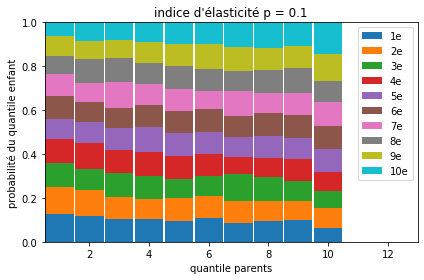

In [12]:
# coefficient d'élasticité du pays que je souhaite étudier (p est le coef, j le pays - voir generate_incomes)
pj = 0.1 
# nombre de quantiles (nombre de classes de revenu)
nb_quantiles = 10 
# taille de l'échantillon
n = 1000 * nb_quantiles 

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
# Cette instruction prendra du temps si nb_quantiles > 10
plot_conditional_distributions(pj, cd, nb_quantiles) 
print(cd)

# Classe de revenu de l'enfant
c_i_child = 5
# Classe de revenu du parent
c_i_parent = 8
# Proba de la classe parent connaissant la classe enfant (cd étant la distribution conditionnelle)
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))

generate_incomes(n,pj)

plt.savefig('fig11-2.jpeg')

##### Représentation avec nb_quantiles = 10 et pj = 0.9 (très faible mobilité)

[[0.442 0.227 0.129 0.085 0.043 0.038 0.023 0.011 0.001 0.001]
 [0.231 0.199 0.178 0.127 0.104 0.078 0.041 0.029 0.01  0.003]
 [0.134 0.173 0.163 0.118 0.124 0.094 0.089 0.056 0.039 0.01 ]
 [0.095 0.128 0.138 0.165 0.131 0.112 0.089 0.074 0.048 0.02 ]
 [0.049 0.094 0.109 0.138 0.135 0.122 0.136 0.105 0.074 0.038]
 [0.023 0.062 0.103 0.108 0.13  0.145 0.132 0.121 0.115 0.061]
 [0.014 0.061 0.078 0.109 0.124 0.115 0.13  0.15  0.146 0.073]
 [0.009 0.033 0.05  0.071 0.116 0.133 0.14  0.175 0.147 0.126]
 [0.001 0.017 0.041 0.06  0.063 0.101 0.131 0.148 0.208 0.23 ]
 [0.002 0.006 0.011 0.019 0.03  0.062 0.089 0.131 0.212 0.438]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.115


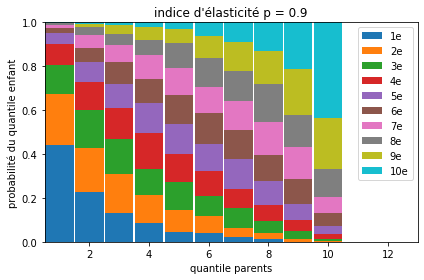

In [13]:
# coefficient d'élasticité du pays que je souhaite étudier (p est le coef, j le pays - voir generate_incomes)
pj = 0.9 
# nombre de quantiles (nombre de classes de revenu)
nb_quantiles = 10 
# taille de l'échantillon
n = 1000 * nb_quantiles 

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
# Cette instruction prendra du temps si nb_quantiles > 10
plot_conditional_distributions(pj, cd, nb_quantiles) 
print(cd)

# Classe de revenu de l'enfant
c_i_child = 5
# Classe de revenu du parent
c_i_parent = 8
# Proba de la classe parent connaissant la classe enfant (cd étant la distribution conditionnelle)
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))

generate_incomes(n,pj)

plt.savefig('fig11-3.jpeg')

### Etape 7.

Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer
(nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.

In [22]:
del y_parents, y_child

### Etape 8. Création de 499 "clones"

La taille de
votre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income
Distribution

In [23]:
%%time 
inc7 = pd.concat([inc5] * 500, ignore_index = True)

Wall time: 265 ms


In [24]:
inc7.shape

(5600000, 7)

In [25]:
len(inc5) * 500

5600000

Nous avons bien 500 fois plus de lignes. 

In [25]:
inc7.head(1)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171


In [53]:
# On vérifie le nombre d'occurrences par pays
inc7[inc7['country_code']=='FRA']['country_code'].count()

50000

In [26]:
%%time

country_list = inc5['country_code'].unique()
classe_parent = 0
classe_enfant = 0
list_prob = []

for country in country_list:
    # On va chercher le coef d'élasticité pour chaque pays
    pj = inc5.loc[inc5['country_code'] == country,'coef_elast'].iloc[0]
    # nombre de classes de revenu
    nb_quantiles = 100
    # taille de l'échantillon
    n = 50_000 
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    # Pour chaque classe de revenu enfant...
    for c_i_child in range(100):
        # ...pour chaque classe de revenu parent...
        for c_i_parent in range(100):
            # ...on calcule la proba de la classe parent connaissant la classe enfant
            p = proba_cond(c_i_parent, c_i_child, cd)
            # On ajoute chaque nouvelle ligne à la précédente avec la méthode extend
            list_prob.extend([c_i_parent + 1] * (int(p * 500)))

Wall time: 8min 8s


In [27]:
len(list_prob)

5600000

In [29]:
# Vérification du nombre de codes pays
inc7['country_code'].nunique()

112

In [32]:
# Ajout de la colonne classe_parent au df principal
inc7['classe_parent'] = list_prob

In [35]:
# Vérification de 2 lignes au hasard
inc7.sample(2)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast,classe_parent
3666818,IND,19,100,487.31662,2796.0,34.916667,0.528167,51
3753041,BLR,42,100,3160.77640,11651.0,28.080952,0.477171,3


In [17]:
# Enregistrement
inc7.to_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/inc7.csv', index=False)

In [22]:
# Import
inc7i = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P7/inc7.csv')

In [19]:
inc7i.head(2)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast,classe_parent
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171,1
1,ALB,2,100,916.66235,7297.0,31.411111,0.477171,1


In [20]:
inc7i.tail(2)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast,classe_parent
5599998,COD,100,100,2243.12260,303.19305,42.150000,0.673630,100
5599999,LTU,41,100,4882.14065,17571.00000,35.686667,0.346163,100


In [5]:
inc7i.shape

(5600000, 8)

---

<a id='Mission4'></a>

[Haut de page](#Top) 

# <font color='#FFCA36'>Mission 4</font>

Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs
variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des
parents, etc.

<a id='Anova'></a>

# 1. Anova income ~ country

Pour cela pas besoin de prendre le df avec 5M+ de lignes. Les doublons x 500 n'apportent rien (cela ne servira que lorsque nous incluerons les quantiles parents). 

In [10]:
# Pour mémoire
inc5.head(2)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171
1,ALB,2,100,916.66235,7297.0,31.411111,0.477171


## Visualisation des données

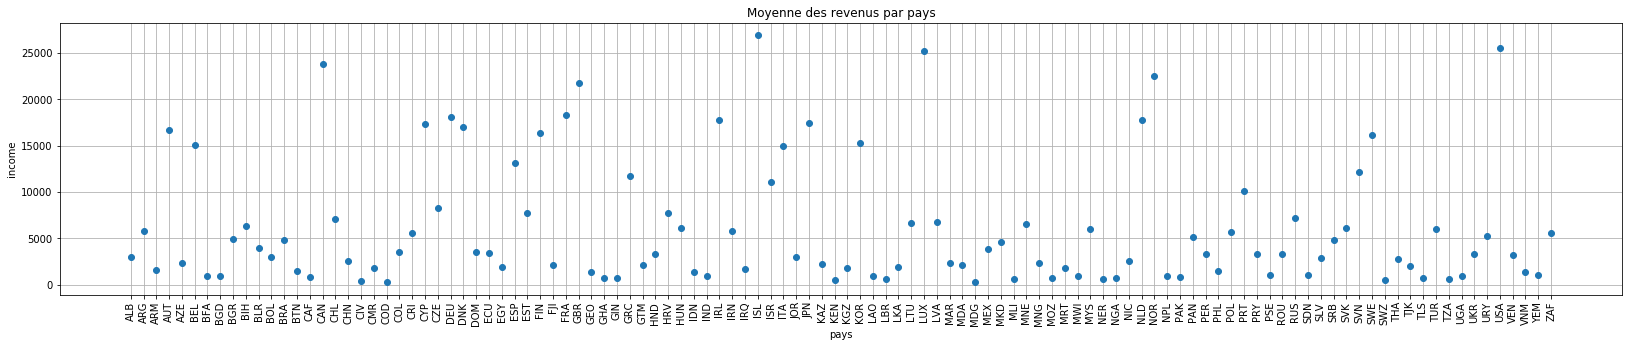

In [15]:
plt.figure(figsize=(28,5))
plt.plot(inc5.groupby('country_code').income.mean(), 'o')
plt.xticks(rotation=90)
plt.grid()
plt.title('Moyenne des revenus par pays')
plt.xlabel('pays')
plt.ylabel('income');

plt.savefig('fig12.jpeg')

On observe bien des valeurs très différentes en fonction des pays. 

## Analyse de la variance : one-way ANOVA

In [24]:
print(st.shapiro(inc5.income))
print(f"Shapiro pvalue : {st.shapiro(inc5.income)[1]}")

(0.5990824699401855, 0.0)
Shapiro pvalue : 0.0


income n'est pas une variable gaussienne. Le modèle qui suit n'est cependant pas remis en cause (en pratique, l'ANOVA présente une certaine robustesse). Il reste robuste parce que nous avons des groupes de taille égale. 

In [12]:
# Modèle
anova_ic = smf.ols('income~country_code', data = inc5).fit()
print(anova_ic.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     97.55
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:47:29   Log-Likelihood:            -1.1458e+05
No. Observations:               11200   AIC:                         2.294e+05
Df Residuals:                   11088   BIC:                         2.302e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2994.8299    

Ce qui nous intéresse réellement, c'est le **test de Fisher** (permettant d'estimer si des variances peuvent être considérées ou non comme identiques).  
La p-valeur de ce test (0) est en dessous du seuil de 5%. On rejette donc l'hypothèse H0 selon laquelle les moyennes de la variable quantitative sont toutes égales entre les p groupes. Le pays a donc bien un effet sur les revenus (voir aussi l'eta² = 0.49), comme on pouvait le supposer avec le graphique.

In [7]:
# Tableau de l'analyse de la variance
res_anova = sm.stats.anova_lm(anova_ic, typ=2)
res_anova 

,sum_sq,df,F,PR(>F)
country_code,4.928326e+11,111.0,97.54556,0.0
Residual,5.046871e+11,11088.0,NaN,NaN


In [9]:
# Vérification pour eta²
eta_sq = res_anova['sum_sq'][0]/(res_anova['sum_sq'][0] + res_anova['sum_sq'][1])
eta_sq

0.4940580385805385

### Analyse de l'Anova

#### Tests statistiques

In [13]:
# Variable
resid0 = anova_ic.resid

In [17]:
# Test d'adequation à une loi Normale avec le test de Shapiro
print(st.shapiro(resid0))
print(f"Shapiro pvalue : {st.shapiro(resid0)[1]}")

(0.5614570379257202, 0.0)
Shapiro pvalue : 0.0


In [8]:
# Test d'adequation à une loi Normale avec le test Kolmogorv-Smirnov
from scipy.stats import ks_2samp
print(ks_2samp(resid0,list(np.random.normal(np.mean(resid0), np.std(resid0), 1000))))

KstestResult(statistic=0.2539285714285714, pvalue=1.153079209761823e-52)


p-value < 0.05 : rejet de H0 et pas d'adhésion à la loi normale.

#### Analyses de forme

Text(0.5, 1.0, 'Residuals Histogram')

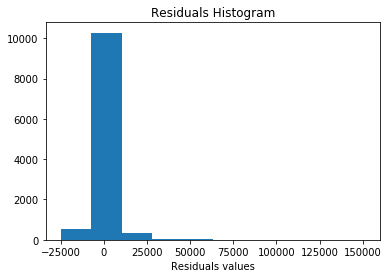

In [21]:
# Normalité : histogramme des résidus
plt.hist(resid0)
plt.xlabel('Residuals values')
plt.title('Residuals Histogram')

# plt.savefig('fig12b.jpeg')

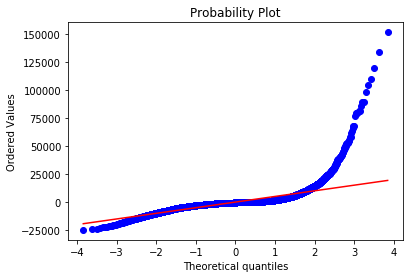

In [22]:
# QQ plot 
fig, ax = plt.subplots()
qq0 = st.probplot(resid0, plot = ax, fit = True)

# plt.savefig('fig12c.jpeg')

Text(0.5, 1.0, 'Residuals vs Fitted')

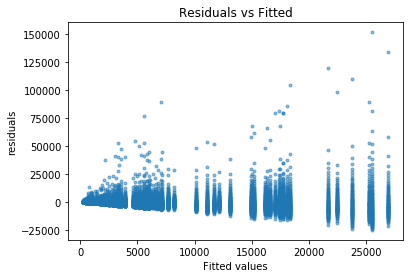

In [26]:
# Nuage de la variance résiduelle, résidus normalisés
fig = plt.figure()
plt.plot(anova_ic.fittedvalues, resid0, '.', alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel('residuals')
plt.title('Residuals vs Fitted')

(Analyse conforme au fait que income n'est pas une variable gaussienne).

<a id='2a'></a>

[Haut de page](#Top) 

# 2. a. Régression linéaire income_mean + gini => income

Régression linéaire sur les données, en n’incluant comme variables explicatives
uniquement **le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu**.

In [4]:
# On va chercher le revenu moyen par pays
inc5_gb = inc5.groupby(['country_code']).mean().reset_index()[['country_code','income']]

In [5]:
inc5_gb.head(2)

,country_code,income
0,ALB,2994.829902
1,ARG,5847.884654


In [5]:
# On ajoute income_mean au df
inc5_m = inc5.merge(inc5_gb, left_on = 'country_code', right_on = 'country_code', suffixes=('_q', '_mean'))
inc5_m.head(2)

,country_code,quantile,nb_quantiles,income_q,gdpppp,mean_gini,coef_elast,income_mean
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171,2994.829902
1,ALB,2,100,916.66235,7297.0,31.411111,0.477171,2994.829902


In [6]:
# On définit les variables
X = inc5_m[['mean_gini', 'income_mean']]
X = sm.add_constant(X)
y = inc5_m['income_q']

In [7]:
# On calcule le modèle
reg_lin1 = sm.OLS(endog = y, exog = X).fit()
reg_lin1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               income_q   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     5467.
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:49:19   Log-Likelihood:            -1.1458e+05
No. Observations:               11200   AIC:                         2.292e+05
Df Residuals:                   11197   BIC:                         2.292e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.381e-11    357.813  -3.86e-14      1.000    -701.377     701.377
mean_gini    1.421e-13      8.406   1.69e-14      1.000     -16.477      16.477
income_mean     1.0000      0.010     95.885      0.000       0.980       1.020
==============================================================================
Omnibus:                    14173.515   Durbin-Watson:                   0.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4100801.951
Skew:                           6.758   Prob(JB):                         0.00
Kurtosis:                      95.762   Cond. No.                     5.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Modèle équivalent à l'ANOVA. R2 est proche de 50%. L'indice de Gini n'est pas significatif, sa p-valeur étant proche de 1. 

### Analyse de la régression

#### Tests statistiques

In [8]:
# Variable
resid1 = reg_lin1.resid

In [56]:
print(f"Shapiro pvalue : {st.shapiro(resid1)[1]}")

Shapiro pvalue : 0.0


C:\Users\chal1\Programmes\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Analyses de forme

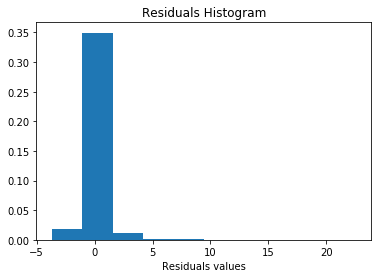

In [65]:
# Normalité : histogramme des résidus
plt.hist(resid1, density=True)
plt.xlabel('Residuals values')
plt.title('Residuals Histogram')

plt.savefig('fig13.jpeg')

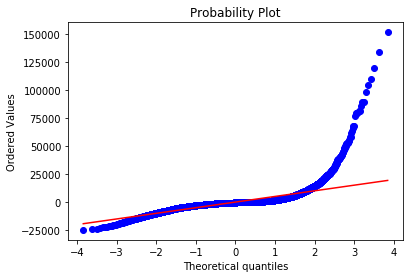

In [66]:
# QQ plot 
fig, ax = plt.subplots()
qq1 = st.probplot(reg_lin1.resid, plot = ax, fit = True)

plt.savefig('fig15.jpeg')

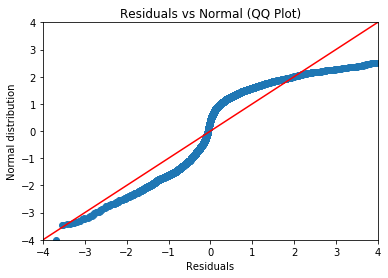

In [77]:
# QQ plot si on prend les résidus normalisés avec resid_pearson : 
resid1b = reg_lin1.resid_pearson

data = pd.Series(resid1b).sort_values()
len_data = len(data)

normal = pd.Series(np.random.normal(size=len_data)).sort_values()
fig, ax = plt.subplots()
plt.scatter(data, normal)
plt.plot((-4,4), (-4, 4), c = 'r')
plt.xlabel("Residuals")
plt.ylabel("Normal distribution")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Residuals vs Normal (QQ Plot)")

plt.savefig('fig15-1.jpeg')

On constate que les données ne sont pas linéaires : la régression linéaire n'est pas un modèle viable. 

In [81]:
# Homoscédasticité : Breush-Pagan test
from statsmodels.compat import lzip
names = ['Lagrande multiplier statistic', 'p-value', 'f-value', 'f p-value']
# Homoscédasticité - test de Breusch-Pagan
breusch_pagan = sm.stats.diagnostic.het_breuschpagan(resid1, X)
print(lzip(names, breusch_pagan))

[('Lagrande multiplier statistic', 319.0594032765642), ('p-value', 5.213518018166511e-70), ('f-value', 164.163571463825), ('f p-value', 5.369831264204363e-71)]


p-value < 0.05 => nous rejettons l’hypothèse nulle d’homoscédasticité des résidus.

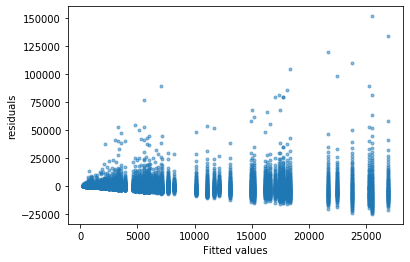

In [84]:
# Homoscédasticité : nuage de la variance résiduelle (résidus non normalisés)
fig = plt.figure()
plt.plot(reg_lin1.fittedvalues, reg_lin1.resid, '.', alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel('residuals')
plt.title('Residuals vs Fitted')

plt.savefig('fig16.jpeg')

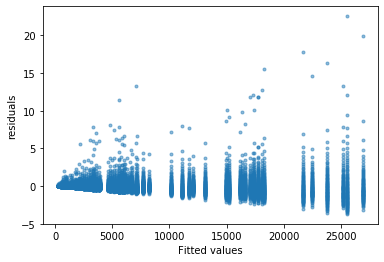

In [85]:
# Nuage de la variance résiduelle, résidus normalisés, pour vérifier 
# (le fait de prendre les résidus normalisés ne fait que changer l'échelle de y)
fig = plt.figure()
plt.plot(reg_lin1.fittedvalues, resid1b, '.', alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel('residuals')
plt.title('Residuals vs Fitted')

plt.savefig('fig17.jpeg')

Text(0.5, 1.0, 'Actual vs Predict')

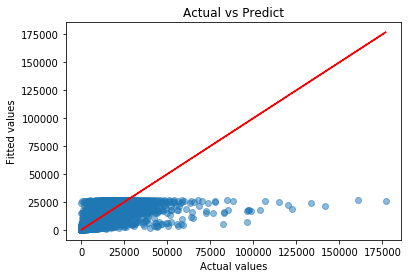

In [44]:
fig, ax = plt.subplots()
plt.scatter(y, reg_lin1.fittedvalues, alpha=0.5)
plt.plot(y, y, c = 'r')
plt.xlabel("Actual values")
plt.ylabel("Fitted values")
plt.title("Actual vs Predict")

plt.savefig('fig18.jpeg')

Les points ne suivent pas du tout la diagonale. 

In [33]:
# Vérification de la colinéarité des variables
variables = reg_lin1.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1892548363142124, 1.1892548363142124]

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Valeurs atypiques et/ou influentes

cf. par ex. http://eric.univ-lyon2.fr/~ricco/cours/slides/Reg_Multiple_Points_Atypiques.pdf

##### Leviers

Individus atypiques (distance à la moyenne des observations).
On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [9]:
# n est le nombre d'individus de l'échantillon, et p, le nombre de variables.
n = len(resid1)
p = X.shape[1]

In [10]:
# cf. https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html
from statsmodels.stats import outliers_influence
influences = outliers_influence.OLSInfluence(reg_lin1)

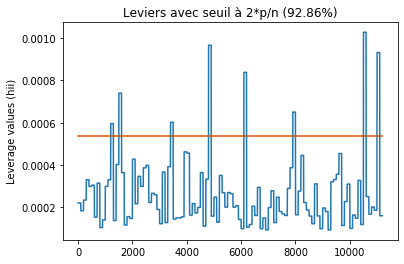

In [12]:
# Calcul de la proportion
# l’effet de levier reflète le poids de chaque donnée sur sa propre estimation
data = influences.hat_matrix_diag
seuil = 2*p/n
len_data = len(data)
data_filter = data[data <= seuil]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (seuil, seuil), c="#d35400")
plt.ylabel("Leverage values (hii)")
plt.title(f"Leviers avec seuil à 2*p/n ({ratio:.2%})")

plt.savefig('fig19.jpeg')

##### Résidus studentisés

Individus mal représentés par le modèle.    
Principe : Comparer la valeur de y et la prédiction de y. Normaliser le résidu par l’écart-type.
Résidu élevé = Point mal reconstitué par le modèle. Ne suit pas la liaison qui a été mise en avant par la régression.

In [13]:
# # Calcul du seuil sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté
# alpha = 0.05
# from scipy.stats import t
# seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
# seuil_rstudent

1.9601758926634487

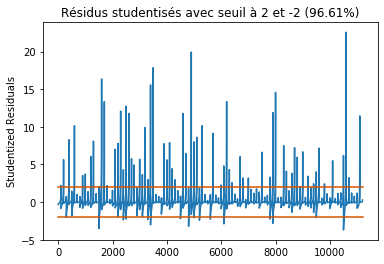

In [16]:
# Calcul de la proportion
# le plot des résidus studentizés permet également de mettre en évidence les outliers
data = influences.resid_studentized_internal
len_data = len(data)
data_filter = data[data <= 2]
data_filter = data_filter[data_filter >= -2]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (2, 2), c="#d35400")
plt.plot((0, len_data), (-2, -2), c="#d35400")
plt.ylabel("Studentized Residuals")
plt.title(f"Résidus studentisés avec seuil à 2 et -2 ({ratio:.2%})")

plt.savefig('fig20.jpeg')

##### Distances de Cook

Outliers dont la supression influencent fortement le modèle.  
Principe : Comparer globalement les coefficients lorsque le point n°i participe ou pas à la régression. On
mesure l’influence d’un point sur les coefficients estimés.

Text(0.5, 1.0, 'Distances de Cook avec seuil à 4/(n-p) (94.96%)')

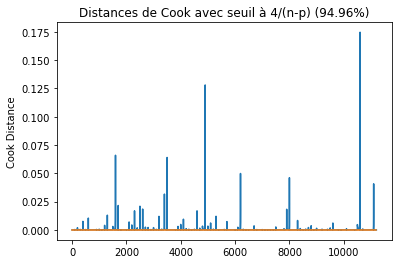

In [55]:
# Calcul de la proportion
# le plot des distance de Cook permet d’évaluer l’influence des données sur les paramètres de régression
data = influences.cooks_distance[0]
seuil = 4/(n-p)
len_data = len(data)
data_filter = data[data <= seuil]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (seuil, seuil))
plt.ylabel("Cook Distance")
plt.title(f"Distances de Cook avec seuil à 4/(n-p) ({ratio:.2%})")

plt.savefig('fig21.jpeg')

<a id='2b'></a>

[Haut de page](#Top) 

## 2. b. Régression linéaire : log(income_mean) + gini => log(income)

In [12]:
# Préparation des données
gini = inc5_m.mean_gini
income_mean = np.log(inc5_m.income_mean)
income_q = np.log(inc5_m.income_q)

temp = pd.concat([gini, income_mean, income_q], axis = 1)

In [13]:
# On définit les variables
X = temp.iloc[:,:-1]
X = sm.add_constant(X)
y = temp.iloc[:,-1]

In [14]:
# On calcule le modèle
reg_lin2 = sm.OLS(endog = y, exog = X).fit()
reg_lin2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               income_q   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                 1.469e+04
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:52:12   Log-Likelihood:                -12311.
No. Observations:               11200   AIC:                         2.463e+04
Df Residuals:                   11197   BIC:                         2.465e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5117      0.070      7.261      0.000       0.374       0.650
mean_gini      -0.0167      0.001    -18.969      0.000      -0.018      -0.015
income_mean     0.9826      0.006    154.960      0.000       0.970       0.995
==============================================================================
Omnibus:                      753.353   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3457.146
Skew:                          -0.139   Prob(JB):                         0.00
Kurtosis:                       5.708   Cond. No.                         412.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analyse de la régression

#### Tests statistiques

In [15]:
# On prend les résidus normalisés
# cf. https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.resid_pearson.html
resid2 = reg_lin2.resid_pearson
resid2

array([-1.73429956, -1.41877329, -1.28404053, ...,  2.25053488,
        2.52008462,  3.28529137])

In [61]:
# from statsmodels.compat import lzip
# names = ['Lagrande multiplier statistic', 'p-value', 'f-value', 'f p-value']
# Homoscédasticité - test de Breusch-Pagan
breusch_pagan2 = sm.stats.diagnostic.het_breuschpagan(resid2, X)
print(lzip(names, breusch_pagan2))

[('Lagrande multiplier statistic', 561.1448824617512), ('p-value', 1.409084375533597e-122), ('f-value', 295.29207699080433), ('f p-value', 1.0567384905371309e-125)]


In [62]:
print(f"Shapiro pvalue : {st.shapiro(resid2)[1]}")

Shapiro pvalue : 5.274160076397345e-38


C:\Users\chal1\Programmes\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Analyses de forme

Text(0.5, 1.0, 'Histogramme des résidus de -5 à 5 (99.94%)')

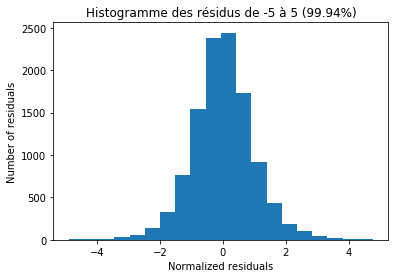

In [63]:
# Histogramme des résidus
data = resid2
data_filter = data[data < 5]
data_filter = data[data > -5]
len_data = len(data)
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

fig, ax = plt.subplots()
plt.hist(data_filter, bins=20)
plt.xlabel("Normalized residuals")
plt.ylabel("Number of residuals")
plt.title(f"Histogramme des résidus de -5 à 5 ({ratio:.2%})")

plt.savefig('fig22.jpeg')

Text(0.5, 1.0, 'Residuals vs Normal (QQ Plot)')

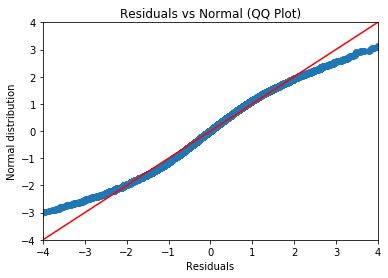

In [65]:
# QQ plot
data = pd.Series(resid2).sort_values()
len_data = len(data)

normal = pd.Series(np.random.normal(size=len_data)).sort_values()
fig, ax = plt.subplots()
plt.scatter(data, normal)
plt.plot((-4,4), (-4, 4), c = 'r')
plt.xlabel("Residuals")
plt.ylabel("Normal distribution")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Residuals vs Normal (QQ Plot)")

plt.savefig('fig23.jpeg')

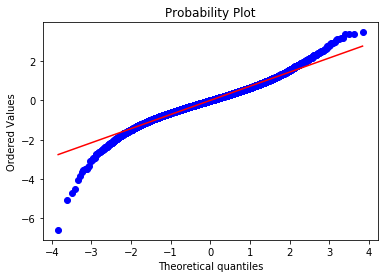

In [73]:
# Résultat si on ne normalise pas les résidus, pour voir
fig, ax = plt.subplots()
d2 = st.probplot(reg_lin2.resid, plot = ax, fit = True)

plt.savefig('fig24.jpeg')

Text(0, 0.5, 'residuals')

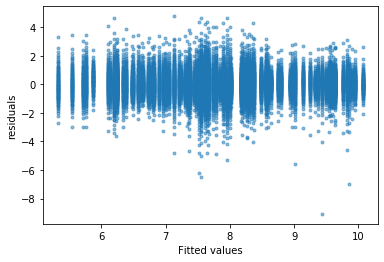

In [77]:
# Nuage de la variance résiduelle (le fait de prendre les résidus normalisés ne fait que changer l'échelle de y)
fig = plt.figure()
plt.plot(reg_lin2.fittedvalues, resid2, '.', alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.savefig('fig25.jpeg')

Text(0.5, 1.0, 'Actual vs Predict')

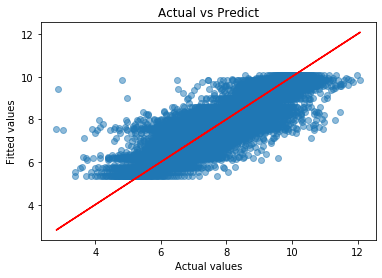

In [68]:
# Actual vs Predict
fig, ax = plt.subplots()
plt.scatter(y, reg_lin2.fittedvalues, alpha=0.5)
plt.plot(y, y, c = 'r')
plt.xlabel("Actual values")
plt.ylabel("Fitted values")
plt.title("Actual vs Predict")

plt.savefig('fig26.jpeg')

In [43]:
# Vérification de la colinéarité des variables
variables = reg_lin2.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.118083961905408, 1.1180839619054068]

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Valeurs atypiques et/ou influentes

##### Leviers (hii, diagonale de la matrice chapeau)

Individus atypiques (distance à la moyenne des observations)

In [17]:
# from statsmodels.stats import outliers_influence
influences = outliers_influence.OLSInfluence(reg_lin2)
# n est le nombre d\'individus de l'échantillon, et p, le nombre de variables.
n = len(resid2)
p = X.shape[1]

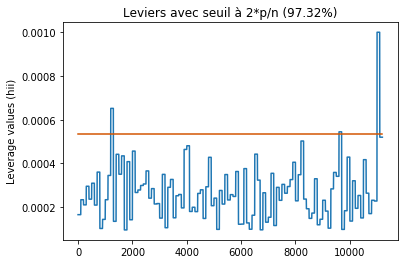

In [18]:
# Calcul de la proportion
data = influences.hat_matrix_diag
seuil = 2*p/n
len_data = len(data)
data_filter = data[data <= seuil]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (seuil, seuil), c="#d35400")
plt.ylabel("Leverage values (hii)")
plt.title(f"Leviers avec seuil à 2*p/n ({ratio:.2%})")

plt.savefig('fig27.jpeg')

##### Résidus studentisés

Individus mal représentés par le modèle

In [40]:
# # Calcul du seuil sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté
# alpha = 0.05
# # from scipy.stats import t
# seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
# seuil_rstudent

1.9601758926634487

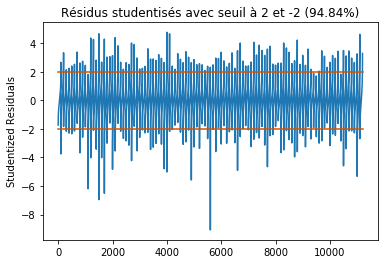

In [20]:
# Calcul de la proportion
data = influences.resid_studentized_internal
len_data = len(data)
data_filter = data[data <= 2]
data_filter = data_filter[data_filter >= -2]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (2, 2), c="#d35400")
plt.plot((0, len_data), (-2, -2), c="#d35400")
plt.ylabel("Studentized Residuals")
plt.title(f"Résidus studentisés avec seuil à 2 et -2 ({ratio:.2%})")

plt.savefig('fig28.jpeg')

##### Distances de Cook

Outliers dont la supression influencent fortement le modèle

Text(0.5, 1.0, 'Distances de Cook avec seuil à 4/(n-p) (94.22%)')

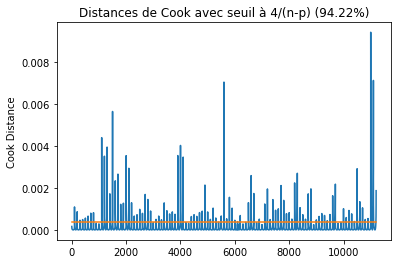

In [72]:
# Calcul de la proportion
data = influences.cooks_distance[0]
seuil = 4/(n-p)
len_data = len(data)
data_filter = data[data <= seuil]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (seuil, seuil))
plt.ylabel("Cook Distance")
plt.title(f"Distances de Cook avec seuil à 4/(n-p) ({ratio:.2%})")

plt.savefig('fig29.jpeg')

In [11]:
reg_lin2_cook,_ = reg_lin2.get_influence().cooks_distance
reg_lin2_cook

array([1.66003720e-04, 1.11095277e-04, 9.09969962e-05, ...,
       8.79294508e-04, 1.10253685e-03, 1.87374571e-03])

In [33]:
# Calcul du seuil, usuellement considéré a 4/(n-p)
n, p = X.shape
reg_lin2_cook_seuil = 4 / (n-p)
print(f'Distance de Cooks au-delà de laquelle on considère que les individus sont des outliers sont influents : 
      {reg_lin2_cook_seuil:.1e}')
# on compte le nombre d'outliers
reg_lin2_nb_outlier = np.sum(reg_lin2_cook > reg_lin2_cook_seuil)
print(f'Nombre d\'outliers influents dans notre cas : {reg_lin2_nb_outlier}')

print(f'En pourcentage : {reg_lin2_nb_outlier / n * 100:.1f} %')

Distance de Cooks au-delà de laquelle on considère que les individus sont des outliers sont influents : 3.6e-04
Nombre d'outliers influents dans notre cas : 647
En pourcentage : 5.8 %


### Interprétation

Les résultats sont clairement meilleurs.  
Toutes les p-values sont < 0.05.  
72% de la variance peut être expliquée par notre modèle. Le reste peut être expliqué par d'autres facteurs comme par exemple les revenus des parents, le lien d'habitation, le niveau d'études.  

<a id='3'></a>

[Haut de page](#Top) 

## 3. Régression linéaire : log(income_mean) + gini + c_parent => log(income)

Nous utilisons cette fois le fichier avec 5M+ de lignes, comprenant les classe_parent.

In [40]:
# Pour mémoire
inc7i.head(2)

,country_code,quantile,nb_quantiles,income,gdpppp,mean_gini,coef_elast,classe_parent
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171,1
1,ALB,2,100,916.66235,7297.0,31.411111,0.477171,1


### Préparation du df

In [23]:
# Copie du df principal
reg3 = inc7i.copy()

In [24]:
# On va chercher la moyenne du revenu par pays
reg3_gb = reg3.groupby(['country_code']).mean().reset_index()[['country_code','income']]

In [83]:
reg3_gb.head(2)

,country_code,income
0,ALB,2994.829902
1,ARG,5847.884654


In [25]:
# On ajoute income_mean au df
reg3 = reg3.merge(reg3_gb, left_on = 'country_code', right_on = 'country_code', suffixes=('_q', '_mean'))

In [85]:
reg3.head(2)

,country_code,quantile,nb_quantiles,income_q,gdpppp,mean_gini,coef_elast,classe_parent,income_mean
0,ALB,1,100,728.89795,7297.0,31.411111,0.477171,1,2994.829902
1,ALB,2,100,916.66235,7297.0,31.411111,0.477171,1,2994.829902


In [26]:
# Préparation des données
gini3 = reg3.mean_gini
c_parent = reg3.classe_parent
income_mean3 = np.log(reg3.income_mean)
income_q3 = np.log(reg3.income_q)

temp = pd.concat([gini3, c_parent, income_mean3, income_q3], axis = 1)

In [27]:
# On définit les variables
X3 = temp.iloc[:,:-1]
X3 = sm.add_constant(X3)
y3 = temp.iloc[:,-1]

In [28]:
# On calcule le modèle
reg_lin3 = sm.OLS(endog = y3, exog = X3).fit()
reg_lin3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               income_q   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                 5.090e+06
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:58:32   Log-Likelihood:            -6.0776e+06
No. Observations:             5600000   AIC:                         1.216e+07
Df Residuals:                 5599996   BIC:                         1.216e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3011      0.003     95.505      0.000       0.295       0.307
mean_gini        -0.0167   3.89e-05   -429.971      0.000      -0.017      -0.017
classe_parent     0.0042   1.05e-05    397.231      0.000       0.004       0.004
income_mean       0.9826      0.000   3513.955      0.000       0.982       0.983
==============================================================================
Omnibus:                   396746.449   Durbin-Watson:                   0.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1913090.410
Skew:                          -0.155   Prob(JB):                         0.00
Kurtosis:                       5.847   Cond. No.                         713.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analyse de la régression

#### Tests statistiques

In [29]:
# On prend les résidus normalisés
# cf. https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.resid_pearson.html
resid3 = reg_lin3.resid_pearson
resid3

array([-1.47088405, -1.15090059, -1.01426457, ...,  1.9944353 ,
        2.26779276,  3.04380898])

In [92]:
# from statsmodels.compat import lzip
# names = ['Lagrande multiplier statistic', 'p-value', 'f-value', 'f p-value']
# Homoscédasticité - test de Breusch-Pagan
breusch_pagan3 = sm.stats.diagnostic.het_breuschpagan(resid3, X3)
print(lzip(names, breusch_pagan3))

[('Lagrande multiplier statistic', 273686.6455083279), ('p-value', 0.0), ('f-value', 95916.50722837391), ('f p-value', 0.0)]


In [93]:
print(f"Shapiro pvalue : {st.shapiro(resid3)[1]}")

Shapiro pvalue : 0.0


C:\Users\chal1\Programmes\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Analyses de forme

Text(0.5, 1.0, 'Histogramme des résidus de -5 à 5 (99.93%)')

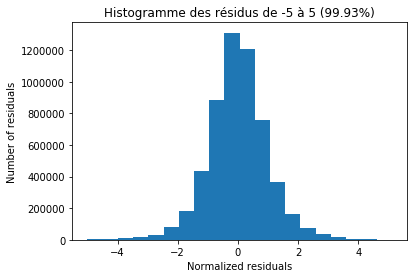

In [94]:
# Histogramme des résidus
data = resid3
data_filter = data[data < 5]
data_filter = data[data > -5]
len_data = len(data)
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

fig, ax = plt.subplots()
plt.hist(data_filter, bins=20)
plt.xlabel("Normalized residuals")
plt.ylabel("Number of residuals")
plt.title(f"Histogramme des résidus de -5 à 5 ({ratio:.2%})")

plt.savefig('fig30.jpeg')

Text(0.5, 1.0, 'Residuals vs Normal (QQ Plot)')

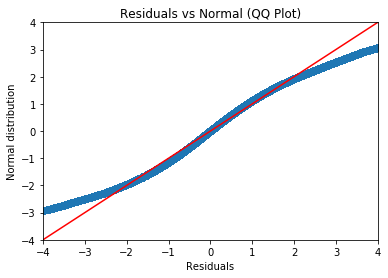

In [95]:
# QQ plot
data = pd.Series(resid3).sort_values()
len_data = len(data)

normal = pd.Series(np.random.normal(size=len_data)).sort_values()
fig, ax = plt.subplots()
plt.scatter(data, normal)
plt.plot((-4,4), (-4, 4), c = 'r')
plt.xlabel("Residuals")
plt.ylabel("Normal distribution")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Residuals vs Normal (QQ Plot)")

plt.savefig('fig31.jpeg')

Text(0.5, 1.0, 'Fitted vs residuals')

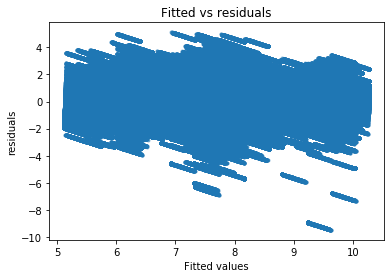

In [97]:
# Nuage de la variance résiduelle
fig = plt.figure()
plt.plot(reg_lin3.fittedvalues, resid3, '.', alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel('residuals')
plt.title('Fitted vs residuals')

plt.savefig('fig32.jpeg')

Text(0.5, 1.0, 'Actual vs Predict')

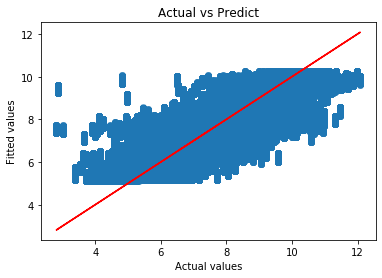

In [99]:
fig, ax = plt.subplots()
plt.scatter(y3, reg_lin3.fittedvalues, alpha=0.5)
plt.plot(y3, y3, c = 'r')
plt.xlabel("Actual values")
plt.ylabel("Fitted values")
plt.title("Actual vs Predict")

plt.savefig('fig33.jpeg')

In [31]:
# Vérification de la colinéarité des variables
variables = reg_lin3.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1180841736370752, 1.0000002157719885, 1.118083962073075]

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Valeurs atypiques et/ou influentes

##### Leviers (hii, diagonale de la matrice chapeau)

Individus atypiques (distance à la moyenne des observations)

In [30]:
# from statsmodels.stats import outliers_influence
influences = outliers_influence.OLSInfluence(reg_lin3)
# n est le nombre d\'individus de l'échantillon, et p, le nombre de variables.
n = len(resid3)
p = X3.shape[1]

Text(0.5, 1.0, 'Leviers avec seuil à 2*p/n (98.15%)')

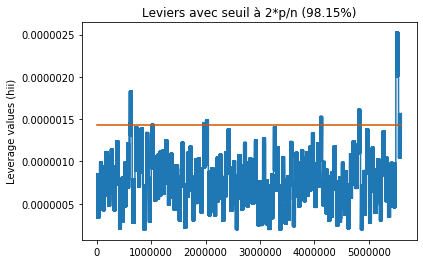

In [101]:
# Calcul de la proportion
data = influences.hat_matrix_diag
seuil = 2*p/n
len_data = len(data)
data_filter = data[data <= seuil]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (seuil, seuil), c="#d35400")
plt.ylabel("Leverage values (hii)")
plt.title(f"Leviers avec seuil à 2*p/n ({ratio:.2%})")

plt.savefig('fig34.jpeg')

##### Résidus studentisés

Individus mal représentés par le modèle

In [33]:
# # Calcul du seuil sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté
# alpha = 0.05
# # from scipy.stats import t
# seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
# seuil_rstudent

1.9599644081603846

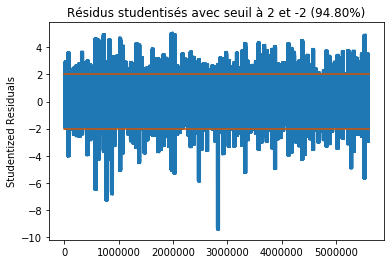

In [31]:
# Calcul de la proportion
data = influences.resid_studentized_internal
len_data = len(data)
data_filter = data[data <= 2]
data_filter = data_filter[data_filter >= -2]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (2, 2), c="#d35400")
plt.plot((0, len_data), (-2, -2), c="#d35400")
plt.ylabel("Studentized Residuals")
plt.title(f"Résidus studentisés avec seuil à 2 et -2 ({ratio:.2%})")

plt.savefig('fig35.jpeg')

##### Distances de Cook

Outliers dont la supression influencent fortement le modèle

Text(0.5, 1.0, 'Distances de Cook avec seuil à 4/(n-p) (94.31%)')

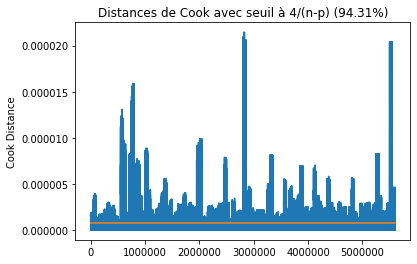

In [103]:
# Calcul de la proportion
data = influences.cooks_distance[0]
seuil = 4/(n-p)
len_data = len(data)
data_filter = data[data <= seuil]
len_data_filter = len(data_filter)
ratio = len_data_filter / len_data

# Plot
fig, ax = plt.subplots()
plt.plot(data)
plt.plot((0, len_data), (seuil, seuil))
plt.ylabel("Cook Distance")
plt.title(f"Distances de Cook avec seuil à 4/(n-p) ({ratio:.2%})")

plt.savefig('fig36.jpeg')

In [58]:
reg_lin3_cook,_ = reg_lin3.get_influence().cooks_distance
reg_lin3_cook

array([4.63194529e-07, 2.83584289e-07, 2.20246518e-07, ...,
       1.55710719e-06, 2.01319264e-06, 3.62671471e-06])

In [59]:
# Calcul du seuil, usuellement considéré a 4 / (n-p)
n, p = X3.shape
reg_lin3_cook_seuil = 4 / (n-p)
print(f'Distance de Cooks au-delà de laquelle on considère que les individus sont des outliers sont influents : {reg_lin3_cook_seuil:.1e}')
# on compte le nombre d'outliers
reg_lin3_nb_outlier = np.sum(reg_lin3_cook > reg_lin3_cook_seuil)
print(f'Nombre d\'outliers influents dans notre cas : {reg_lin3_nb_outlier}')

print(f'En pourcentage : {reg_lin3_nb_outlier / n * 100:.1f} %')

Distance de Cooks au-delà de laquelle on considère que les individus sont des outliers sont influents : 7.1e-07
Nombre d'outliers influents dans notre cas : 318378
En pourcentage : 5.7 %


### Interprétation

Le coefficient de détermination est meilleur (0.732).
Il reste 27 % non expliqués. Le reste peut être expliqué par d'autres facteurs comme par exemple les revenus des parents, le lieu d'habitation, le niveau d'études, les efforts, la chance, etc.  
Ajouter ces facteurs nous permettrait d'améliorer le modèle.  
Le coefficient de régression associé à l'indice de Gini vaut - 0,0167. 
Cela signifie que pour toute valeur égale par ailleurs, lorsque le coef de Gini augmente de 1, le log du revenu diminue de 0,0167, autrement dit le revenu sera divisé par e(0.0167) = 1,0168.